In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.cluster import KMeans
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [3]:
data = pd.read_csv("D:\\Data\\研赛建模\\B题\\training_set_2ap_loc0_nav82.csv")

In [4]:
def str_to_float_list(s):
    try:
        return [float(x) for x in ast.literal_eval(s)]
    except:
        return []

In [5]:
rssi_columns = [
    'ap_from_ap_0_sum_ant_rssi',
    'ap_from_ap_0_max_ant_rssi',
    'ap_from_ap_0_mean_ant_rssi',
    'ap_from_ap_1_sum_ant_rssi',
    'ap_from_ap_1_max_ant_rssi',
    'ap_from_ap_1_mean_ant_rssi',
    'sta_to_ap_0_sum_ant_rssi',
    'sta_to_ap_0_max_ant_rssi',
    'sta_to_ap_0_mean_ant_rssi',
    'sta_to_ap_1_sum_ant_rssi',
    'sta_to_ap_1_max_ant_rssi',
    'sta_to_ap_1_mean_ant_rssi',
    'sta_from_ap_0_sum_ant_rssi',
    'sta_from_ap_0_max_ant_rssi',
    'sta_from_ap_0_mean_ant_rssi',
    'sta_from_ap_1_sum_ant_rssi',
    'sta_from_ap_1_max_ant_rssi',
    'sta_from_ap_1_mean_ant_rssi'
]

In [6]:
for col in rssi_columns:
    data[f"{col}_list"] = data[col].apply(str_to_float_list)


In [7]:
grouped_data = data.groupby('test_id')


In [8]:
def kmeans_filter_rssi(rssi_list, n_clusters=2):
    if len(rssi_list) <= 1:
        return rssi_list
    rssi_array = np.array(rssi_list).reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    if centers[0] < centers[1]:
        noise_label = 0
    else:
        noise_label = 1
    filtered_rssi = [rssi for rssi, label in zip(rssi_list, labels) if label != noise_label]
    return filtered_rssi
    
    

In [9]:
for test_id, group in grouped_data:
    for col in rssi_columns:
        row_1 = group.iloc[0]
        row_2 = group.iloc[1]
        clean_rssi_row1 = kmeans_filter_rssi(row_1[f"{col}_list"])
        clean_rssi_row2 = kmeans_filter_rssi(row_2[f"{col}_list"])
        data.at[row_1.name, f"{col}_list"] = clean_rssi_row1
        data.at[row_2.name, f"{col}_list"] = clean_rssi_row2
        
        
        

C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans

In [10]:
for test_id, group in grouped_data:
    # 检查每个测试是否有两行数据
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue  # 跳过这个测试

    # 获取两行数据
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    ap1_rssi_from_ap0 = data.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = data.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    def calculate_hearing_probability(rssi_list, threshold):
        if not rssi_list:
            return 0
        above_threshold = [rssi for rssi in rssi_list if rssi >= threshold]
        return len(above_threshold) / len(rssi_list)
    pd_threshold_1 = data.at[row_1.name, 'pd']
    pd_threshold_0 = data.at[row_2.name, 'pd']
    # 计算AP1从AP0接收到的互听概率（基于PD门限）
    ap1_hear_prob_pd = calculate_hearing_probability(ap1_rssi_from_ap0, pd_threshold_1)
    # 计算AP0从AP1接收到的互听概率（基于PD门限）
    ap0_hear_prob_pd = calculate_hearing_probability(ap0_rssi_from_ap1, pd_threshold_0)

    # 计算AP之间的互听概率（取最小值）
    ap_pair_hear_prob_pd = min(ap1_hear_prob_pd, ap0_hear_prob_pd)
    data.at[row_1.name, 'ap1_hear_prob_pd'] = ap1_hear_prob_pd
    data.at[row_2.name, 'ap0_hear_prob_pd'] = ap0_hear_prob_pd
    data.at[row_1.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd
    data.at[row_2.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd

In [11]:
SIFS = 16  # 微秒
ACK_duration = 32  # 微秒
def can_hear_each_other(rssi_list, nav_threshold):
    if not rssi_list:
        return False
    return any(rssi >= nav_threshold for rssi in rssi_list)

def calculate_nav_period(seq_time_microseconds):
    return seq_time_microseconds + SIFS + ACK_duration  # 单位：微秒

In [12]:
for test_id, group in grouped_data:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue
    
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    
    # 获取nav_threshold
    nav_threshold = data.at[row_1.name, 'nav']
    print(f"Test ID: {test_id}, NAV Threshold: {nav_threshold}")
    
    # 获取去噪后的RSSI列表
    ap1_rssi_from_ap0 = data.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = data.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    
    print(f"AP1 RSSI from AP0: {ap1_rssi_from_ap0}, AP0 RSSI from AP1: {ap0_rssi_from_ap1}")
    
    # 判断互听情况
    ap1_can_hear_ap0 = can_hear_each_other(ap1_rssi_from_ap0, nav_threshold)
    ap0_can_hear_ap1 = can_hear_each_other(ap0_rssi_from_ap1, nav_threshold)
    
    print(f"AP1 can hear AP0: {ap1_can_hear_ap0}, AP0 can hear AP1: {ap0_can_hear_ap1}")
    
    # 初始化NAV静默总时间
    ap1_nav_silence_time = 0
    ap0_nav_silence_time = 0
    
    # 计算AP1的NAV静默时间
    if ap1_can_hear_ap0:
        seq_time_ap0 = row_2['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap1 = calculate_nav_period(seq_time_ap0)
        num_transmissions_ap0 = row_2['num_ampdu']
        ap1_nav_silence_time = nav_period_ap1 * num_transmissions_ap0
        print(f"AP1 NAV Silence Time: {ap1_nav_silence_time}")
    else:
        ap1_nav_silence_time = 0
        print("AP1 cannot hear AP0, NAV Silence Time set to 0.")
    
    # 计算AP0的NAV静默时间
    if ap0_can_hear_ap1:
        seq_time_ap1 = row_1['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap0 = calculate_nav_period(seq_time_ap1)
        num_transmissions_ap1 = row_1['num_ampdu']
        ap0_nav_silence_time = nav_period_ap0 * num_transmissions_ap1
        print(f"AP0 NAV Silence Time: {ap0_nav_silence_time}")
    else:
        ap0_nav_silence_time = 0
        print("AP0 cannot hear AP1, NAV Silence Time set to 0.")
    
    # 获取测试总时长
    test_duration = row_1['test_dur'] * 1e6  # 将秒转换为微秒
    print(f"Test Duration (in µs): {test_duration}")
    
    # 计算NAV静默比例
    if test_duration != 0:
        ap1_nav_silence_ratio = ap1_nav_silence_time / test_duration
        ap0_nav_silence_ratio = ap0_nav_silence_time / test_duration
    else:
        ap1_nav_silence_ratio = 0
        ap0_nav_silence_ratio = 0
        print("Test duration is 0, silence ratios set to 0.")
    
    print(f"AP1 NAV Silence Ratio: {ap1_nav_silence_ratio}, AP0 NAV Silence Ratio: {ap0_nav_silence_ratio}")
    
    # 存储结果
    data.at[row_1.name, 'ap1_nav_silence_time'] = ap1_nav_silence_time
    data.at[row_2.name, 'ap0_nav_silence_time'] = ap0_nav_silence_time
    data.at[row_1.name, 'ap1_nav_silence_ratio'] = ap1_nav_silence_ratio
    data.at[row_2.name, 'ap0_nav_silence_ratio'] = ap0_nav_silence_ratio


Test ID: 1, NAV Threshold: -82
AP1 RSSI from AP0: [-93.0, -93.0, -94.0, -92.0, -93.0, -93.0, -93.0, -92.0, -93.0, -93.0, -92.0, -92.0, -93.0, -92.0, -92.0, -93.0, -93.0, -93.0, -93.0, -92.0, -92.0, -92.0, -93.0, -93.0, -93.0, -92.0, -92.0, -93.0, -92.0, -93.0, -93.0, -93.0, -93.0, -93.0, -92.0, -93.0, -93.0, -94.0, -93.0, -93.0, -93.0], AP0 RSSI from AP1: [-93.0, -91.0, -92.0, -91.0, -93.0, -93.0, -93.0, -93.0, -93.0, -92.0, -93.0, -93.0, -93.0, -93.0, -89.0, -93.0, -93.0, -93.0, -93.0, -93.0, -93.0, -93.0, -93.0, -93.0, -93.0]
AP1 can hear AP0: False, AP0 can hear AP1: False
AP1 cannot hear AP0, NAV Silence Time set to 0.
AP0 cannot hear AP1, NAV Silence Time set to 0.
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: 0.0, AP0 NAV Silence Ratio: 0.0
Test ID: 2, NAV Threshold: -82
AP1 RSSI from AP0: [-93.0, -93.0, -94.0, -92.0, -93.0, -93.0, -93.0, -92.0, -93.0, -93.0, -92.0, -92.0, -93.0, -92.0, -92.0, -93.0, -93.0, -93.0, -93.0, -92.0, -92.0, -92.0, -93.0, -93.0, -93.0, -92.0,

In [13]:
def calculate_pd_counts(rssi_list, pd_threshold):
    if not rssi_list:
        return 0
    pd_counts = sum(1 for rssi in rssi_list if rssi >= pd_threshold)
    return pd_counts

In [14]:
data.at[row_1.name, 'ap_from_ap_0_max_ant_rssi_list']

[-73.0,
 -72.0,
 -72.0,
 -74.0,
 -73.0,
 -74.0,
 -72.0,
 -74.0,
 -74.0,
 -75.0,
 -75.0,
 -74.0,
 -71.0,
 -73.0,
 -77.0,
 -70.0,
 -71.0,
 -73.0,
 -74.0,
 -73.0,
 -72.0,
 -74.0,
 -71.0,
 -72.0,
 -75.0,
 -74.0,
 -77.0,
 -74.0,
 -73.0,
 -72.0,
 -74.0,
 -74.0,
 -73.0,
 -73.0,
 -72.0,
 -73.0,
 -75.0,
 -70.0,
 -71.0,
 -71.0,
 -72.0,
 -74.0]

In [15]:
for test_id, group in grouped_data:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # print(row_1)
    # 获取ap0的RSSI值，并打印出来进行检查
    ap0_rssi_from_ap1 = data.at[row_1.name, 'ap_from_ap_0_max_ant_rssi_list']
    print(f"测试ID {test_id}: ap0_rssi_from_ap1 = {ap0_rssi_from_ap1}")
    
    # 获取ap0的pd阈值，并打印出来进行检查
    pd_threshold_ap0 = row_1['pd']
    print(f"测试ID {test_id}: pd_threshold_ap0 = {pd_threshold_ap0}")

    # 计算ap0的pd计数，并打印结果
    ap0_pd_counts = calculate_pd_counts(ap0_rssi_from_ap1, pd_threshold_ap0)
    print(f"测试ID {test_id}: ap0_pd_counts = {ap0_pd_counts}")

    # 获取ap1的RSSI值，并打印出来进行检查
    ap1_rssi_from_ap0 = data.at[row_2.name, 'ap_from_ap_1_max_ant_rssi_list']
    print(f"测试ID {test_id}: ap1_rssi_from_ap0 = {ap1_rssi_from_ap0}")

    # 获取ap1的pd阈值，并打印出来进行检查
    pd_threshold_ap1 = row_2['pd']  # 如果pd列有变化，使用AP1的实际PD门限值
    print(f"测试ID {test_id}: pd_threshold_ap1 = {pd_threshold_ap1}")

    # 计算ap1的pd计数，并打印结果
    ap1_pd_counts = calculate_pd_counts(ap1_rssi_from_ap0, pd_threshold_ap1)
    print(f"测试ID {test_id}: ap1_pd_counts = {ap1_pd_counts}")

    # 将计算结果写入data，并打印确认
    data.at[row_1.name, 'ap0_pd_counts'] = ap0_pd_counts
    data.at[row_2.name, 'ap1_pd_counts'] = ap1_pd_counts
    print(f"测试ID {test_id}: 写入数据 - ap0_pd_counts = {ap0_pd_counts}, ap1_pd_counts = {ap1_pd_counts}")


    

测试ID 1: ap0_rssi_from_ap1 = [-89.0, -88.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -88.0, -89.0, -89.0]
测试ID 1: pd_threshold_ap0 = -82
测试ID 1: ap0_pd_counts = 0
测试ID 1: ap1_rssi_from_ap0 = [-86.0, -85.0, -84.0]
测试ID 1: pd_threshold_ap1 = -82
测试ID 1: ap1_pd_counts = 0
测试ID 1: 写入数据 - ap0_pd_counts = 0, ap1_pd_counts = 0
测试ID 2: ap0_rssi_from_ap1 = [-89.0, -88.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -89.0, -88.0, -89.0, -89.0]
测试ID 2: pd_threshold_ap0 = -82
测试ID 2: ap0_pd_counts = 0
测试ID 2: ap1_rssi_from_ap0 = [-86.0, -85.0, -84.0]
测试ID 2: pd_threshold_ap1 = -82
测试ID 2: ap1_pd_counts = 0
测试ID 2: 写入数据 - ap0_pd_counts = 0, ap1_pd_counts = 0
测试ID 3: ap0_rssi_from_ap1 = [-88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -86.0, -88.0, -85.0, -87.0, -88.0, -86.0]
测试ID 3: pd_threshold_ap0 = -82
测试ID 3: ap0_pd_counts = 0
测试ID 3: ap1_rssi_from_ap0 = [-86.0, -81.0, -82.0, -85.0, -82.0, -84.0, -85.0, -85

In [16]:
for test_id, group in grouped_data:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # 在每个group的循环中添加
    actual_air_time_ap0 = row_1['ppdu_dur'] * row_1['num_ampdu']
    actual_air_time_ap1 = row_2['ppdu_dur'] * row_2['num_ampdu']

    channel_utilization_ap0 = actual_air_time_ap0 / row_1['test_dur']
    channel_utilization_ap1 = actual_air_time_ap1 / row_2['test_dur']

    # 存储结果
    data.at[row_1.name, 'channel_utilization'] = channel_utilization_ap0
    data.at[row_2.name, 'channel_utilization'] = channel_utilization_ap1

In [17]:
for test_id, group in grouped_data:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # 计算AP0的冲突次数和重传率
    estimated_collisions_ap0 = row_1['per'] * row_1['num_ampdu']
    retransmission_rate_ap0 = estimated_collisions_ap0 / row_1['num_ampdu']

    # 计算AP1的冲突次数和重传率
    estimated_collisions_ap1 = row_2['per'] * row_2['num_ampdu']
    retransmission_rate_ap1 = estimated_collisions_ap1 / row_2['num_ampdu']

    # 存储结果
    data.at[row_1.name, 'retransmission_rate'] = retransmission_rate_ap0
    data.at[row_2.name, 'retransmission_rate'] = retransmission_rate_ap1


In [18]:
new_col = 'mean_rssi_value'
def list_mean(lst):
    return sum(lst) / len(lst) if lst else None
data[new_col] = data.apply(lambda row: list_mean(row['ap_from_ap_0_mean_ant_rssi_list']) 
                           if row.name % 2 == 0 
                           else list_mean(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)


In [19]:
new_col_2 = 'std_rssi_value'
def list_std(lst):
    return np.std(lst) if lst else None

data[new_col_2] = data.apply(lambda row: list_std(row['ap_from_ap_0_mean_ant_rssi_list'])
                             if row.name % 2 == 0
                             else list_std(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)

In [20]:
new_col_3 = 'combined_hear_prob_pd'

# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data[new_col_3] = data.apply(lambda row: alternate_values(row.name, data['ap1_hear_prob_pd'], data['ap0_hear_prob_pd']), axis=1)

In [21]:
new_col_3 = 'nav_silence_time'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data[new_col_3] = data.apply(lambda row: alternate_values(row.name, data['ap1_nav_silence_time'], data['ap0_nav_silence_time']), axis=1)

In [22]:
new_col_4 = 'nav_silence_ratio'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data[new_col_4] = data.apply(lambda row: alternate_values(row.name, data['ap1_nav_silence_ratio'], data['ap0_nav_silence_ratio']), axis=1)

In [23]:
new_col_5 = 'pd_counts'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data[new_col_5] = data.apply(lambda row: alternate_values(row.name, data['ap0_pd_counts'], data['ap1_pd_counts']), axis=1)

In [24]:
data_2 = pd.read_csv("D:\\Data\\研赛建模\\B题\\training_set_2ap_loc0_nav86.csv")

In [25]:
for col in rssi_columns:
    data_2[f"{col}_list"] = data_2[col].apply(str_to_float_list)

In [26]:
grouped_data_2 = data_2.groupby('test_id')
for test_id, group in grouped_data_2:
    for col in rssi_columns:
        row_1 = group.iloc[0]
        row_2 = group.iloc[1]
        clean_rssi_row1 = kmeans_filter_rssi(row_1[f"{col}_list"])
        clean_rssi_row2 = kmeans_filter_rssi(row_2[f"{col}_list"])
        data_2.at[row_1.name, f"{col}_list"] = clean_rssi_row1
        data_2.at[row_2.name, f"{col}_list"] = clean_rssi_row2

C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans

In [27]:
for test_id, group in grouped_data_2:
    # 检查每个测试是否有两行数据
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue  # 跳过这个测试

    # 获取两行数据
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    ap1_rssi_from_ap0 = data_2.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = data_2.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    def calculate_hearing_probability(rssi_list, threshold):
        if not rssi_list:
            return 0
        above_threshold = [rssi for rssi in rssi_list if rssi >= threshold]
        return len(above_threshold) / len(rssi_list)
    pd_threshold_1 = data_2.at[row_1.name, 'pd']
    pd_threshold_0 = data_2.at[row_2.name, 'pd']
    # 计算AP1从AP0接收到的互听概率（基于PD门限）
    ap1_hear_prob_pd = calculate_hearing_probability(ap1_rssi_from_ap0, pd_threshold_1)
    # 计算AP0从AP1接收到的互听概率（基于PD门限）
    ap0_hear_prob_pd = calculate_hearing_probability(ap0_rssi_from_ap1, pd_threshold_0)

    # 计算AP之间的互听概率（取最小值）
    ap_pair_hear_prob_pd = min(ap1_hear_prob_pd, ap0_hear_prob_pd)
    data_2.at[row_1.name, 'ap1_hear_prob_pd'] = ap1_hear_prob_pd
    data_2.at[row_2.name, 'ap0_hear_prob_pd'] = ap0_hear_prob_pd
    data_2.at[row_1.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd
    data_2.at[row_2.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd

In [28]:
SIFS = 16  # 微秒
ACK_duration = 32  # 微秒
def can_hear_each_other(rssi_list, nav_threshold):
    if not rssi_list:
        return False
    return any(rssi >= nav_threshold for rssi in rssi_list)

def calculate_nav_period(seq_time_microseconds):
    return seq_time_microseconds + SIFS + ACK_duration  # 单位：微秒

In [29]:
for test_id, group in grouped_data_2:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue
    
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    
    # 获取nav_threshold
    nav_threshold = data_2.at[row_1.name, 'nav']
    # print(f"Test ID: {test_id}, NAV Threshold: {nav_threshold}")
    
    # 获取去噪后的RSSI列表
    ap1_rssi_from_ap0 = data_2.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = data_2.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    
    # print(f"AP1 RSSI from AP0: {ap1_rssi_from_ap0}, AP0 RSSI from AP1: {ap0_rssi_from_ap1}")
    
    # 判断互听情况
    ap1_can_hear_ap0 = can_hear_each_other(ap1_rssi_from_ap0, nav_threshold)
    ap0_can_hear_ap1 = can_hear_each_other(ap0_rssi_from_ap1, nav_threshold)
    
    # print(f"AP1 can hear AP0: {ap1_can_hear_ap0}, AP0 can hear AP1: {ap0_can_hear_ap1}")
    
    # 初始化NAV静默总时间
    ap1_nav_silence_time = 0
    ap0_nav_silence_time = 0
    
    # 计算AP1的NAV静默时间
    if ap1_can_hear_ap0:
        seq_time_ap0 = row_2['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap1 = calculate_nav_period(seq_time_ap0)
        num_transmissions_ap0 = row_2['num_ampdu']
        ap1_nav_silence_time = nav_period_ap1 * num_transmissions_ap0
        # print(f"AP1 NAV Silence Time: {ap1_nav_silence_time}")
    else:
        ap1_nav_silence_time = 0
        # print("AP1 cannot hear AP0, NAV Silence Time set to 0.")
    
    # 计算AP0的NAV静默时间
    if ap0_can_hear_ap1:
        seq_time_ap1 = row_1['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap0 = calculate_nav_period(seq_time_ap1)
        num_transmissions_ap1 = row_1['num_ampdu']
        ap0_nav_silence_time = nav_period_ap0 * num_transmissions_ap1
        # print(f"AP0 NAV Silence Time: {ap0_nav_silence_time}")
    else:
        ap0_nav_silence_time = 0
        # print("AP0 cannot hear AP1, NAV Silence Time set to 0.")
    
    # 获取测试总时长
    test_duration = row_1['test_dur'] * 1e6  # 将秒转换为微秒
    # print(f"Test Duration (in µs): {test_duration}")
    
    # 计算NAV静默比例
    if test_duration != 0:
        ap1_nav_silence_ratio = ap1_nav_silence_time / test_duration
        ap0_nav_silence_ratio = ap0_nav_silence_time / test_duration
    else:
        ap1_nav_silence_ratio = 0
        ap0_nav_silence_ratio = 0
        # print("Test duration is 0, silence ratios set to 0.")
    
    # print(f"AP1 NAV Silence Ratio: {ap1_nav_silence_ratio}, AP0 NAV Silence Ratio: {ap0_nav_silence_ratio}")
    
    # 存储结果
    data_2.at[row_1.name, 'ap1_nav_silence_time'] = ap1_nav_silence_time
    data_2.at[row_2.name, 'ap0_nav_silence_time'] = ap0_nav_silence_time
    data_2.at[row_1.name, 'ap1_nav_silence_ratio'] = ap1_nav_silence_ratio
    data_2.at[row_2.name, 'ap0_nav_silence_ratio'] = ap0_nav_silence_ratio


In [30]:
for test_id, group in grouped_data_2:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # print(row_1)
    # 获取ap0的RSSI值，并打印出来进行检查
    ap0_rssi_from_ap1 = data_2.at[row_1.name, 'ap_from_ap_0_max_ant_rssi_list']
    # print(f"测试ID {test_id}: ap0_rssi_from_ap1 = {ap0_rssi_from_ap1}")
    
    # 获取ap0的pd阈值，并打印出来进行检查
    pd_threshold_ap0 = row_1['pd']
    # print(f"测试ID {test_id}: pd_threshold_ap0 = {pd_threshold_ap0}")

    # 计算ap0的pd计数，并打印结果
    ap0_pd_counts = calculate_pd_counts(ap0_rssi_from_ap1, pd_threshold_ap0)
    # print(f"测试ID {test_id}: ap0_pd_counts = {ap0_pd_counts}")

    # 获取ap1的RSSI值，并打印出来进行检查
    ap1_rssi_from_ap0 = data_2.at[row_2.name, 'ap_from_ap_1_max_ant_rssi_list']
    # print(f"测试ID {test_id}: ap1_rssi_from_ap0 = {ap1_rssi_from_ap0}")

    # 获取ap1的pd阈值，并打印出来进行检查
    pd_threshold_ap1 = row_2['pd']  # 如果pd列有变化，使用AP1的实际PD门限值
    # print(f"测试ID {test_id}: pd_threshold_ap1 = {pd_threshold_ap1}")

    # 计算ap1的pd计数，并打印结果
    ap1_pd_counts = calculate_pd_counts(ap1_rssi_from_ap0, pd_threshold_ap1)
    # print(f"测试ID {test_id}: ap1_pd_counts = {ap1_pd_counts}")

    # 将计算结果写入data，并打印确认
    data_2.at[row_1.name, 'ap0_pd_counts'] = ap0_pd_counts
    data_2.at[row_2.name, 'ap1_pd_counts'] = ap1_pd_counts
    # print(f"测试ID {test_id}: 写入数据 - ap0_pd_counts = {ap0_pd_counts}, ap1_pd_counts = {ap1_pd_counts}")


    

In [31]:
for test_id, group in grouped_data_2:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # 在每个group的循环中添加
    actual_air_time_ap0 = row_1['ppdu_dur'] * row_1['num_ampdu']
    actual_air_time_ap1 = row_2['ppdu_dur'] * row_2['num_ampdu']

    channel_utilization_ap0 = actual_air_time_ap0 / row_1['test_dur']
    channel_utilization_ap1 = actual_air_time_ap1 / row_2['test_dur']

    # 存储结果
    data_2.at[row_1.name, 'channel_utilization'] = channel_utilization_ap0
    data_2.at[row_2.name, 'channel_utilization'] = channel_utilization_ap1

In [32]:
for test_id, group in grouped_data_2:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # 计算AP0的冲突次数和重传率
    estimated_collisions_ap0 = row_1['per'] * row_1['num_ampdu']
    retransmission_rate_ap0 = estimated_collisions_ap0 / row_1['num_ampdu']

    # 计算AP1的冲突次数和重传率
    estimated_collisions_ap1 = row_2['per'] * row_2['num_ampdu']
    retransmission_rate_ap1 = estimated_collisions_ap1 / row_2['num_ampdu']

    # 存储结果
    data_2.at[row_1.name, 'retransmission_rate'] = retransmission_rate_ap0
    data_2.at[row_2.name, 'retransmission_rate'] = retransmission_rate_ap1


In [33]:
new_col = 'mean_rssi_value'
def list_mean(lst):
    return sum(lst) / len(lst) if lst else None
data_2[new_col] = data_2.apply(lambda row: list_mean(row['ap_from_ap_0_mean_ant_rssi_list']) 
                           if row.name % 2 == 0 
                           else list_mean(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)


In [34]:
new_col_2 = 'std_rssi_value'
def list_std(lst):
    return np.std(lst) if lst else None

data_2[new_col_2] = data_2.apply(lambda row: list_std(row['ap_from_ap_0_mean_ant_rssi_list'])
                             if row.name % 2 == 0
                             else list_std(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)

In [35]:
new_col_3 = 'combined_hear_prob_pd'

# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_2[new_col_3] = data_2.apply(lambda row: alternate_values(row.name, data_2['ap1_hear_prob_pd'], data_2['ap0_hear_prob_pd']), axis=1)

In [36]:
new_col_4 = 'nav_silence_ratio'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_2[new_col_4] = data_2.apply(lambda row: alternate_values(row.name, data_2['ap1_nav_silence_ratio'], data_2['ap0_nav_silence_ratio']), axis=1)

In [37]:
new_col_5 = 'pd_counts'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_2[new_col_5] = data_2.apply(lambda row: alternate_values(row.name, data_2['ap0_pd_counts'], data_2['ap1_pd_counts']), axis=1)

In [38]:
data_2.columns

Index(['test_id', 'test_dur', 'loc_id', 'protocol', 'pkt_len', 'bss_id',
       'ap_name', 'ap_mac', 'ap_id', 'pd', 'ed', 'nav', 'eirp',
       'ap_from_ap_0_sum_ant_rssi', 'ap_from_ap_0_max_ant_rssi',
       'ap_from_ap_0_mean_ant_rssi', 'ap_from_ap_1_sum_ant_rssi',
       'ap_from_ap_1_max_ant_rssi', 'ap_from_ap_1_mean_ant_rssi', 'sta_mac',
       'sta_id', 'sta_to_ap_0_sum_ant_rssi', 'sta_to_ap_0_max_ant_rssi',
       'sta_to_ap_0_mean_ant_rssi', 'sta_to_ap_1_sum_ant_rssi',
       'sta_to_ap_1_max_ant_rssi', 'sta_to_ap_1_mean_ant_rssi',
       'sta_from_ap_0_sum_ant_rssi', 'sta_from_ap_0_max_ant_rssi',
       'sta_from_ap_0_mean_ant_rssi', 'sta_from_ap_1_sum_ant_rssi',
       'sta_from_ap_1_max_ant_rssi', 'sta_from_ap_1_mean_ant_rssi',
       'sta_from_sta_0_rssi', 'sta_from_sta_1_rssi', 'nss', 'mcs', 'per',
       'num_ampdu', 'ppdu_dur', 'other_air_time', 'seq_time', 'throughput',
       'ap_from_ap_0_sum_ant_rssi_list', 'ap_from_ap_0_max_ant_rssi_list',
       'ap_from_ap_0_mean_

In [39]:
data_3 = pd.read_csv("D:\\Data\\研赛建模\B题\\training_set_2ap_loc1_nav82.csv")

In [40]:
for col in rssi_columns:
    data_3[f"{col}_list"] = data_3[col].apply(str_to_float_list)

In [41]:
grouped_data_3 = data_3.groupby('test_id')
for test_id, group in grouped_data_3:
    for col in rssi_columns:
        row_1 = group.iloc[0]
        row_2 = group.iloc[1]
        clean_rssi_row1 = kmeans_filter_rssi(row_1[f"{col}_list"])
        clean_rssi_row2 = kmeans_filter_rssi(row_2[f"{col}_list"])
        data_3.at[row_1.name, f"{col}_list"] = clean_rssi_row1
        data_3.at[row_2.name, f"{col}_list"] = clean_rssi_row2

C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans

In [42]:
for test_id, group in grouped_data_3:
    # 检查每个测试是否有两行数据
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue  # 跳过这个测试

    # 获取两行数据
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    ap1_rssi_from_ap0 = data_3.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = data_3.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    def calculate_hearing_probability(rssi_list, threshold):
        if not rssi_list:
            return 0
        above_threshold = [rssi for rssi in rssi_list if rssi >= threshold]
        return len(above_threshold) / len(rssi_list)
    pd_threshold_1 = data_3.at[row_1.name, 'pd']
    pd_threshold_0 = data_3.at[row_2.name, 'pd']
    # 计算AP1从AP0接收到的互听概率（基于PD门限）
    ap1_hear_prob_pd = calculate_hearing_probability(ap1_rssi_from_ap0, pd_threshold_1)
    # 计算AP0从AP1接收到的互听概率（基于PD门限）
    ap0_hear_prob_pd = calculate_hearing_probability(ap0_rssi_from_ap1, pd_threshold_0)

    # 计算AP之间的互听概率（取最小值）
    ap_pair_hear_prob_pd = min(ap1_hear_prob_pd, ap0_hear_prob_pd)
    data_3.at[row_1.name, 'ap1_hear_prob_pd'] = ap1_hear_prob_pd
    data_3.at[row_2.name, 'ap0_hear_prob_pd'] = ap0_hear_prob_pd
    data_3.at[row_1.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd
    data_3.at[row_2.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd

In [43]:
for test_id, group in grouped_data_3:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue
    
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    
    # 获取nav_threshold
    nav_threshold = data_3.at[row_1.name, 'nav']
    # print(f"Test ID: {test_id}, NAV Threshold: {nav_threshold}")
    
    # 获取去噪后的RSSI列表
    ap1_rssi_from_ap0 = data_3.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = data_3.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    
    # print(f"AP1 RSSI from AP0: {ap1_rssi_from_ap0}, AP0 RSSI from AP1: {ap0_rssi_from_ap1}")
    
    # 判断互听情况
    ap1_can_hear_ap0 = can_hear_each_other(ap1_rssi_from_ap0, nav_threshold)
    ap0_can_hear_ap1 = can_hear_each_other(ap0_rssi_from_ap1, nav_threshold)
    
    # print(f"AP1 can hear AP0: {ap1_can_hear_ap0}, AP0 can hear AP1: {ap0_can_hear_ap1}")
    
    # 初始化NAV静默总时间
    ap1_nav_silence_time = 0
    ap0_nav_silence_time = 0
    
    # 计算AP1的NAV静默时间
    if ap1_can_hear_ap0:
        seq_time_ap0 = row_2['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap1 = calculate_nav_period(seq_time_ap0)
        num_transmissions_ap0 = row_2['num_ampdu']
        ap1_nav_silence_time = nav_period_ap1 * num_transmissions_ap0
        # print(f"AP1 NAV Silence Time: {ap1_nav_silence_time}")
    else:
        ap1_nav_silence_time = 0
        # print("AP1 cannot hear AP0, NAV Silence Time set to 0.")
    
    # 计算AP0的NAV静默时间
    if ap0_can_hear_ap1:
        seq_time_ap1 = row_1['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap0 = calculate_nav_period(seq_time_ap1)
        num_transmissions_ap1 = row_1['num_ampdu']
        ap0_nav_silence_time = nav_period_ap0 * num_transmissions_ap1
        # print(f"AP0 NAV Silence Time: {ap0_nav_silence_time}")
    else:
        ap0_nav_silence_time = 0
        # print("AP0 cannot hear AP1, NAV Silence Time set to 0.")
    
    # 获取测试总时长
    test_duration = row_1['test_dur'] * 1e6  # 将秒转换为微秒
    # print(f"Test Duration (in µs): {test_duration}")
    
    # 计算NAV静默比例
    if test_duration != 0:
        ap1_nav_silence_ratio = ap1_nav_silence_time / test_duration
        ap0_nav_silence_ratio = ap0_nav_silence_time / test_duration
    else:
        ap1_nav_silence_ratio = 0
        ap0_nav_silence_ratio = 0
        # print("Test duration is 0, silence ratios set to 0.")
    
    # print(f"AP1 NAV Silence Ratio: {ap1_nav_silence_ratio}, AP0 NAV Silence Ratio: {ap0_nav_silence_ratio}")
    
    # 存储结果
    data_3.at[row_1.name, 'ap1_nav_silence_time'] = ap1_nav_silence_time
    data_3.at[row_2.name, 'ap0_nav_silence_time'] = ap0_nav_silence_time
    data_3.at[row_1.name, 'ap1_nav_silence_ratio'] = ap1_nav_silence_ratio
    data_3.at[row_2.name, 'ap0_nav_silence_ratio'] = ap0_nav_silence_ratio


In [44]:
for test_id, group in grouped_data_3:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # print(row_1)
    # 获取ap0的RSSI值，并打印出来进行检查
    ap0_rssi_from_ap1 = data_3.at[row_1.name, 'ap_from_ap_0_max_ant_rssi_list']
    # print(f"测试ID {test_id}: ap0_rssi_from_ap1 = {ap0_rssi_from_ap1}")
    
    # 获取ap0的pd阈值，并打印出来进行检查
    pd_threshold_ap0 = row_1['pd']
    # print(f"测试ID {test_id}: pd_threshold_ap0 = {pd_threshold_ap0}")

    # 计算ap0的pd计数，并打印结果
    ap0_pd_counts = calculate_pd_counts(ap0_rssi_from_ap1, pd_threshold_ap0)
    # print(f"测试ID {test_id}: ap0_pd_counts = {ap0_pd_counts}")

    # 获取ap1的RSSI值，并打印出来进行检查
    ap1_rssi_from_ap0 = data_3.at[row_2.name, 'ap_from_ap_1_max_ant_rssi_list']
    # print(f"测试ID {test_id}: ap1_rssi_from_ap0 = {ap1_rssi_from_ap0}")

    # 获取ap1的pd阈值，并打印出来进行检查
    pd_threshold_ap1 = row_2['pd']  # 如果pd列有变化，使用AP1的实际PD门限值
    # print(f"测试ID {test_id}: pd_threshold_ap1 = {pd_threshold_ap1}")

    # 计算ap1的pd计数，并打印结果
    ap1_pd_counts = calculate_pd_counts(ap1_rssi_from_ap0, pd_threshold_ap1)
    # print(f"测试ID {test_id}: ap1_pd_counts = {ap1_pd_counts}")

    # 将计算结果写入data，并打印确认
    data_3.at[row_1.name, 'ap0_pd_counts'] = ap0_pd_counts
    data_3.at[row_2.name, 'ap1_pd_counts'] = ap1_pd_counts
    # print(f"测试ID {test_id}: 写入数据 - ap0_pd_counts = {ap0_pd_counts}, ap1_pd_counts = {ap1_pd_counts}")


    

In [45]:
for test_id, group in grouped_data_3:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # 在每个group的循环中添加
    actual_air_time_ap0 = row_1['ppdu_dur'] * row_1['num_ampdu']
    actual_air_time_ap1 = row_2['ppdu_dur'] * row_2['num_ampdu']

    channel_utilization_ap0 = actual_air_time_ap0 / row_1['test_dur']
    channel_utilization_ap1 = actual_air_time_ap1 / row_2['test_dur']

    # 存储结果
    data_3.at[row_1.name, 'channel_utilization'] = channel_utilization_ap0
    data_3.at[row_2.name, 'channel_utilization'] = channel_utilization_ap1

In [46]:
for test_id, group in grouped_data_3:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # 计算AP0的冲突次数和重传率
    estimated_collisions_ap0 = row_1['per'] * row_1['num_ampdu']
    retransmission_rate_ap0 = estimated_collisions_ap0 / row_1['num_ampdu']

    # 计算AP1的冲突次数和重传率
    estimated_collisions_ap1 = row_2['per'] * row_2['num_ampdu']
    retransmission_rate_ap1 = estimated_collisions_ap1 / row_2['num_ampdu']

    # 存储结果
    data_3.at[row_1.name, 'retransmission_rate'] = retransmission_rate_ap0
    data_3.at[row_2.name, 'retransmission_rate'] = retransmission_rate_ap1


In [47]:
new_col = 'mean_rssi_value'
def list_mean(lst):
    return sum(lst) / len(lst) if lst else None
data_3[new_col] = data_3.apply(lambda row: list_mean(row['ap_from_ap_0_mean_ant_rssi_list']) 
                           if row.name % 2 == 0 
                           else list_mean(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)


In [48]:
new_col_2 = 'std_rssi_value'
def list_std(lst):
    return np.std(lst) if lst else None

data_3[new_col_2] = data_3.apply(lambda row: list_std(row['ap_from_ap_0_mean_ant_rssi_list'])
                             if row.name % 2 == 0
                             else list_std(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)

In [49]:
new_col_3 = 'combined_hear_prob_pd'

# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_3[new_col_3] = data_3.apply(lambda row: alternate_values(row.name, data_3['ap1_hear_prob_pd'], data_3['ap0_hear_prob_pd']), axis=1)

In [50]:
new_col_4 = 'nav_silence_ratio'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_3[new_col_4] = data_3.apply(lambda row: alternate_values(row.name, data_3['ap1_nav_silence_ratio'], data_3['ap0_nav_silence_ratio']), axis=1)

In [51]:
new_col_5 = 'pd_counts'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_3[new_col_5] = data_3.apply(lambda row: alternate_values(row.name, data_3['ap0_pd_counts'], data_3['ap1_pd_counts']), axis=1)

In [52]:
data_4 = pd.read_csv("D:\\Data\\研赛建模\B题\\training_set_2ap_loc1_nav86.csv")

In [53]:
for col in rssi_columns:
    data_4[f"{col}_list"] = data_4[col].apply(str_to_float_list)

In [54]:
grouped_data_4 = data_4.groupby('test_id')
for test_id, group in grouped_data_4:
    for col in rssi_columns:
        row_1 = group.iloc[0]
        row_2 = group.iloc[1]
        clean_rssi_row1 = kmeans_filter_rssi(row_1[f"{col}_list"])
        clean_rssi_row2 = kmeans_filter_rssi(row_2[f"{col}_list"])
        data_4.at[row_1.name, f"{col}_list"] = clean_rssi_row1
        data_4.at[row_2.name, f"{col}_list"] = clean_rssi_row2

C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans

In [55]:
for test_id, group in grouped_data_4:
    # 检查每个测试是否有两行数据
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue  # 跳过这个测试

    # 获取两行数据
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    ap1_rssi_from_ap0 = data_4.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = data_4.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    def calculate_hearing_probability(rssi_list, threshold):
        if not rssi_list:
            return 0
        above_threshold = [rssi for rssi in rssi_list if rssi >= threshold]
        return len(above_threshold) / len(rssi_list)
    pd_threshold_1 = data_4.at[row_1.name, 'pd']
    pd_threshold_0 = data_4.at[row_2.name, 'pd']
    # 计算AP1从AP0接收到的互听概率（基于PD门限）
    ap1_hear_prob_pd = calculate_hearing_probability(ap1_rssi_from_ap0, pd_threshold_1)
    # 计算AP0从AP1接收到的互听概率（基于PD门限）
    ap0_hear_prob_pd = calculate_hearing_probability(ap0_rssi_from_ap1, pd_threshold_0)

    # 计算AP之间的互听概率（取最小值）
    ap_pair_hear_prob_pd = min(ap1_hear_prob_pd, ap0_hear_prob_pd)
    data_4.at[row_1.name, 'ap1_hear_prob_pd'] = ap1_hear_prob_pd
    data_4.at[row_2.name, 'ap0_hear_prob_pd'] = ap0_hear_prob_pd
    data_4.at[row_1.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd
    data_4.at[row_2.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd

In [56]:
for test_id, group in grouped_data_4:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue
    
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    
    # 获取nav_threshold
    nav_threshold = data_4.at[row_1.name, 'nav']
    # print(f"Test ID: {test_id}, NAV Threshold: {nav_threshold}")
    
    # 获取去噪后的RSSI列表
    ap1_rssi_from_ap0 = data_4.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = data_4.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    
    # print(f"AP1 RSSI from AP0: {ap1_rssi_from_ap0}, AP0 RSSI from AP1: {ap0_rssi_from_ap1}")
    
    # 判断互听情况
    ap1_can_hear_ap0 = can_hear_each_other(ap1_rssi_from_ap0, nav_threshold)
    ap0_can_hear_ap1 = can_hear_each_other(ap0_rssi_from_ap1, nav_threshold)
    
    # print(f"AP1 can hear AP0: {ap1_can_hear_ap0}, AP0 can hear AP1: {ap0_can_hear_ap1}")
    
    # 初始化NAV静默总时间
    ap1_nav_silence_time = 0
    ap0_nav_silence_time = 0
    
    # 计算AP1的NAV静默时间
    if ap1_can_hear_ap0:
        seq_time_ap0 = row_2['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap1 = calculate_nav_period(seq_time_ap0)
        num_transmissions_ap0 = row_2['num_ampdu']
        ap1_nav_silence_time = nav_period_ap1 * num_transmissions_ap0
        # print(f"AP1 NAV Silence Time: {ap1_nav_silence_time}")
    else:
        ap1_nav_silence_time = 0
        # print("AP1 cannot hear AP0, NAV Silence Time set to 0.")
    
    # 计算AP0的NAV静默时间
    if ap0_can_hear_ap1:
        seq_time_ap1 = row_1['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap0 = calculate_nav_period(seq_time_ap1)
        num_transmissions_ap1 = row_1['num_ampdu']
        ap0_nav_silence_time = nav_period_ap0 * num_transmissions_ap1
        # print(f"AP0 NAV Silence Time: {ap0_nav_silence_time}")
    else:
        ap0_nav_silence_time = 0
        # print("AP0 cannot hear AP1, NAV Silence Time set to 0.")
    
    # 获取测试总时长
    test_duration = row_1['test_dur'] * 1e6  # 将秒转换为微秒
    # print(f"Test Duration (in µs): {test_duration}")
    
    # 计算NAV静默比例
    if test_duration != 0:
        ap1_nav_silence_ratio = ap1_nav_silence_time / test_duration
        ap0_nav_silence_ratio = ap0_nav_silence_time / test_duration
    else:
        ap1_nav_silence_ratio = 0
        ap0_nav_silence_ratio = 0
        # print("Test duration is 0, silence ratios set to 0.")
    
    # print(f"AP1 NAV Silence Ratio: {ap1_nav_silence_ratio}, AP0 NAV Silence Ratio: {ap0_nav_silence_ratio}")
    
    # 存储结果
    data_4.at[row_1.name, 'ap1_nav_silence_time'] = ap1_nav_silence_time
    data_4.at[row_2.name, 'ap0_nav_silence_time'] = ap0_nav_silence_time
    data_4.at[row_1.name, 'ap1_nav_silence_ratio'] = ap1_nav_silence_ratio
    data_4.at[row_2.name, 'ap0_nav_silence_ratio'] = ap0_nav_silence_ratio


In [57]:
for test_id, group in grouped_data_4:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # print(row_1)
    # 获取ap0的RSSI值，并打印出来进行检查
    ap0_rssi_from_ap1 = data_4.at[row_1.name, 'ap_from_ap_0_max_ant_rssi_list']
    # print(f"测试ID {test_id}: ap0_rssi_from_ap1 = {ap0_rssi_from_ap1}")
    
    # 获取ap0的pd阈值，并打印出来进行检查
    pd_threshold_ap0 = row_1['pd']
    # print(f"测试ID {test_id}: pd_threshold_ap0 = {pd_threshold_ap0}")

    # 计算ap0的pd计数，并打印结果
    ap0_pd_counts = calculate_pd_counts(ap0_rssi_from_ap1, pd_threshold_ap0)
    # print(f"测试ID {test_id}: ap0_pd_counts = {ap0_pd_counts}")

    # 获取ap1的RSSI值，并打印出来进行检查
    ap1_rssi_from_ap0 = data_4.at[row_2.name, 'ap_from_ap_1_max_ant_rssi_list']
    # print(f"测试ID {test_id}: ap1_rssi_from_ap0 = {ap1_rssi_from_ap0}")

    # 获取ap1的pd阈值，并打印出来进行检查
    pd_threshold_ap1 = row_2['pd']  # 如果pd列有变化，使用AP1的实际PD门限值
    # print(f"测试ID {test_id}: pd_threshold_ap1 = {pd_threshold_ap1}")

    # 计算ap1的pd计数，并打印结果
    ap1_pd_counts = calculate_pd_counts(ap1_rssi_from_ap0, pd_threshold_ap1)
    # print(f"测试ID {test_id}: ap1_pd_counts = {ap1_pd_counts}")

    # 将计算结果写入data，并打印确认
    data_4.at[row_1.name, 'ap0_pd_counts'] = ap0_pd_counts
    data_4.at[row_2.name, 'ap1_pd_counts'] = ap1_pd_counts
    # print(f"测试ID {test_id}: 写入数据 - ap0_pd_counts = {ap0_pd_counts}, ap1_pd_counts = {ap1_pd_counts}")


    

In [58]:
for test_id, group in grouped_data_4:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # 在每个group的循环中添加
    actual_air_time_ap0 = row_1['ppdu_dur'] * row_1['num_ampdu']
    actual_air_time_ap1 = row_2['ppdu_dur'] * row_2['num_ampdu']

    channel_utilization_ap0 = actual_air_time_ap0 / row_1['test_dur']
    channel_utilization_ap1 = actual_air_time_ap1 / row_2['test_dur']

    # 存储结果
    data_4.at[row_1.name, 'channel_utilization'] = channel_utilization_ap0
    data_4.at[row_2.name, 'channel_utilization'] = channel_utilization_ap1

In [59]:
for test_id, group in grouped_data_4:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # 计算AP0的冲突次数和重传率
    estimated_collisions_ap0 = row_1['per'] * row_1['num_ampdu']
    retransmission_rate_ap0 = estimated_collisions_ap0 / row_1['num_ampdu']

    # 计算AP1的冲突次数和重传率
    estimated_collisions_ap1 = row_2['per'] * row_2['num_ampdu']
    retransmission_rate_ap1 = estimated_collisions_ap1 / row_2['num_ampdu']

    # 存储结果
    data_4.at[row_1.name, 'retransmission_rate'] = retransmission_rate_ap0
    data_4.at[row_2.name, 'retransmission_rate'] = retransmission_rate_ap1


In [60]:
new_col = 'mean_rssi_value'
def list_mean(lst):
    return sum(lst) / len(lst) if lst else None
data_4[new_col] = data_4.apply(lambda row: list_mean(row['ap_from_ap_0_mean_ant_rssi_list']) 
                           if row.name % 2 == 0 
                           else list_mean(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)


In [61]:
new_col_2 = 'std_rssi_value'
def list_std(lst):
    return np.std(lst) if lst else None

data_4[new_col_2] = data_4.apply(lambda row: list_std(row['ap_from_ap_0_mean_ant_rssi_list'])
                             if row.name % 2 == 0
                             else list_std(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)

In [62]:
new_col_3 = 'combined_hear_prob_pd'

# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_4[new_col_3] = data_4.apply(lambda row: alternate_values(row.name, data_4['ap1_hear_prob_pd'], data_4['ap0_hear_prob_pd']), axis=1)

In [63]:
new_col_4 = 'nav_silence_ratio'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_4[new_col_4] = data_4.apply(lambda row: alternate_values(row.name, data_4['ap1_nav_silence_ratio'], data_4['ap0_nav_silence_ratio']), axis=1)

In [64]:
new_col_5 = 'pd_counts'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_4[new_col_5] = data_4.apply(lambda row: alternate_values(row.name, data_4['ap0_pd_counts'], data_4['ap1_pd_counts']), axis=1)

In [65]:
data_5 = pd.read_csv('D:\\Data\\研赛建模\\B题\\training_set_2ap_loc2_nav82.csv')
data_5 = data_5[:-2]

In [66]:
for col in rssi_columns:
    data_5[f"{col}_list"] = data_5[col].apply(str_to_float_list)

In [67]:
grouped_data_5 = data_5.groupby('test_id')
for test_id, group in grouped_data_5:
    if len(group) < 2:  # Ensure there are at least two rows
        continue
    for col in rssi_columns:
        row_1 = group.iloc[0]
        row_2 = group.iloc[1]
        clean_rssi_row1 = kmeans_filter_rssi(row_1[f"{col}_list"])
        clean_rssi_row2 = kmeans_filter_rssi(row_2[f"{col}_list"])
        data_5.at[row_1.name, f"{col}_list"] = clean_rssi_row1
        data_5.at[row_2.name, f"{col}_list"] = clean_rssi_row2

C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18976\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans

In [68]:
for test_id, group in grouped_data_5:
    # 检查每个测试是否有两行数据
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue  # 跳过这个测试

    # 获取两行数据
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    ap1_rssi_from_ap0 = data_5.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = data_5.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    def calculate_hearing_probability(rssi_list, threshold):
        if not rssi_list:
            return 0
        above_threshold = [rssi for rssi in rssi_list if rssi >= threshold]
        return len(above_threshold) / len(rssi_list)
    pd_threshold_1 = data_5.at[row_1.name, 'pd']
    pd_threshold_0 = data_5.at[row_2.name, 'pd']
    # 计算AP1从AP0接收到的互听概率（基于PD门限）
    ap1_hear_prob_pd = calculate_hearing_probability(ap1_rssi_from_ap0, pd_threshold_1)
    # 计算AP0从AP1接收到的互听概率（基于PD门限）
    ap0_hear_prob_pd = calculate_hearing_probability(ap0_rssi_from_ap1, pd_threshold_0)

    # 计算AP之间的互听概率（取最小值）
    ap_pair_hear_prob_pd = min(ap1_hear_prob_pd, ap0_hear_prob_pd)
    data_5.at[row_1.name, 'ap1_hear_prob_pd'] = ap1_hear_prob_pd
    data_5.at[row_2.name, 'ap0_hear_prob_pd'] = ap0_hear_prob_pd
    data_5.at[row_1.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd
    data_5.at[row_2.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd

In [69]:
for test_id, group in grouped_data_5:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue
    
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    
    # 获取nav_threshold
    nav_threshold = data_5.at[row_1.name, 'nav']
    # print(f"Test ID: {test_id}, NAV Threshold: {nav_threshold}")
    
    # 获取去噪后的RSSI列表
    ap1_rssi_from_ap0 = data_5.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = data_5.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    
    # print(f"AP1 RSSI from AP0: {ap1_rssi_from_ap0}, AP0 RSSI from AP1: {ap0_rssi_from_ap1}")
    
    # 判断互听情况
    ap1_can_hear_ap0 = can_hear_each_other(ap1_rssi_from_ap0, nav_threshold)
    ap0_can_hear_ap1 = can_hear_each_other(ap0_rssi_from_ap1, nav_threshold)
    
    # print(f"AP1 can hear AP0: {ap1_can_hear_ap0}, AP0 can hear AP1: {ap0_can_hear_ap1}")
    
    # 初始化NAV静默总时间
    ap1_nav_silence_time = 0
    ap0_nav_silence_time = 0
    
    # 计算AP1的NAV静默时间
    if ap1_can_hear_ap0:
        seq_time_ap0 = row_2['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap1 = calculate_nav_period(seq_time_ap0)
        num_transmissions_ap0 = row_2['num_ampdu']
        ap1_nav_silence_time = nav_period_ap1 * num_transmissions_ap0
        # print(f"AP1 NAV Silence Time: {ap1_nav_silence_time}")
    else:
        ap1_nav_silence_time = 0
        # print("AP1 cannot hear AP0, NAV Silence Time set to 0.")
    
    # 计算AP0的NAV静默时间
    if ap0_can_hear_ap1:
        seq_time_ap1 = row_1['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap0 = calculate_nav_period(seq_time_ap1)
        num_transmissions_ap1 = row_1['num_ampdu']
        ap0_nav_silence_time = nav_period_ap0 * num_transmissions_ap1
        # print(f"AP0 NAV Silence Time: {ap0_nav_silence_time}")
    else:
        ap0_nav_silence_time = 0
        # print("AP0 cannot hear AP1, NAV Silence Time set to 0.")
    
    # 获取测试总时长
    test_duration = row_1['test_dur'] * 1e6  # 将秒转换为微秒
    # print(f"Test Duration (in µs): {test_duration}")
    
    # 计算NAV静默比例
    if test_duration != 0:
        ap1_nav_silence_ratio = ap1_nav_silence_time / test_duration
        ap0_nav_silence_ratio = ap0_nav_silence_time / test_duration
    else:
        ap1_nav_silence_ratio = 0
        ap0_nav_silence_ratio = 0
        # print("Test duration is 0, silence ratios set to 0.")
    
    # print(f"AP1 NAV Silence Ratio: {ap1_nav_silence_ratio}, AP0 NAV Silence Ratio: {ap0_nav_silence_ratio}")
    
    # 存储结果
    data_5.at[row_1.name, 'ap1_nav_silence_time'] = ap1_nav_silence_time
    data_5.at[row_2.name, 'ap0_nav_silence_time'] = ap0_nav_silence_time
    data_5.at[row_1.name, 'ap1_nav_silence_ratio'] = ap1_nav_silence_ratio
    data_5.at[row_2.name, 'ap0_nav_silence_ratio'] = ap0_nav_silence_ratio


In [70]:
for test_id, group in grouped_data_5:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # print(row_1)
    # 获取ap0的RSSI值，并打印出来进行检查
    ap0_rssi_from_ap1 = data_5.at[row_1.name, 'ap_from_ap_0_max_ant_rssi_list']
    # print(f"测试ID {test_id}: ap0_rssi_from_ap1 = {ap0_rssi_from_ap1}")
    
    # 获取ap0的pd阈值，并打印出来进行检查
    pd_threshold_ap0 = row_1['pd']
    # print(f"测试ID {test_id}: pd_threshold_ap0 = {pd_threshold_ap0}")

    # 计算ap0的pd计数，并打印结果
    ap0_pd_counts = calculate_pd_counts(ap0_rssi_from_ap1, pd_threshold_ap0)
    # print(f"测试ID {test_id}: ap0_pd_counts = {ap0_pd_counts}")

    # 获取ap1的RSSI值，并打印出来进行检查
    ap1_rssi_from_ap0 = data_5.at[row_2.name, 'ap_from_ap_1_max_ant_rssi_list']
    # print(f"测试ID {test_id}: ap1_rssi_from_ap0 = {ap1_rssi_from_ap0}")

    # 获取ap1的pd阈值，并打印出来进行检查
    pd_threshold_ap1 = row_2['pd']  # 如果pd列有变化，使用AP1的实际PD门限值
    # print(f"测试ID {test_id}: pd_threshold_ap1 = {pd_threshold_ap1}")

    # 计算ap1的pd计数，并打印结果
    ap1_pd_counts = calculate_pd_counts(ap1_rssi_from_ap0, pd_threshold_ap1)
    # print(f"测试ID {test_id}: ap1_pd_counts = {ap1_pd_counts}")

    # 将计算结果写入data，并打印确认
    data_5.at[row_1.name, 'ap0_pd_counts'] = ap0_pd_counts
    data_5.at[row_2.name, 'ap1_pd_counts'] = ap1_pd_counts
    # print(f"测试ID {test_id}: 写入数据 - ap0_pd_counts = {ap0_pd_counts}, ap1_pd_counts = {ap1_pd_counts}")


    

In [71]:
for test_id, group in grouped_data_5:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # 在每个group的循环中添加
    actual_air_time_ap0 = row_1['ppdu_dur'] * row_1['num_ampdu']
    actual_air_time_ap1 = row_2['ppdu_dur'] * row_2['num_ampdu']

    channel_utilization_ap0 = actual_air_time_ap0 / row_1['test_dur']
    channel_utilization_ap1 = actual_air_time_ap1 / row_2['test_dur']

    # 存储结果
    data_5.at[row_1.name, 'channel_utilization'] = channel_utilization_ap0
    data_5.at[row_2.name, 'channel_utilization'] = channel_utilization_ap1

In [72]:
for test_id, group in grouped_data_5:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # 计算AP0的冲突次数和重传率
    estimated_collisions_ap0 = row_1['per'] * row_1['num_ampdu']
    retransmission_rate_ap0 = estimated_collisions_ap0 / row_1['num_ampdu']

    # 计算AP1的冲突次数和重传率
    estimated_collisions_ap1 = row_2['per'] * row_2['num_ampdu']
    retransmission_rate_ap1 = estimated_collisions_ap1 / row_2['num_ampdu']

    # 存储结果
    data_5.at[row_1.name, 'retransmission_rate'] = retransmission_rate_ap0
    data_5.at[row_2.name, 'retransmission_rate'] = retransmission_rate_ap1


In [73]:
new_col = 'mean_rssi_value'
def list_mean(lst):
    return sum(lst) / len(lst) if lst else None
data_5[new_col] = data_5.apply(lambda row: list_mean(row['ap_from_ap_0_mean_ant_rssi_list']) 
                           if row.name % 2 == 0 
                           else list_mean(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)


In [74]:
new_col_2 = 'std_rssi_value'
def list_std(lst):
    return np.std(lst) if lst else None

data_5[new_col_2] = data_5.apply(lambda row: list_std(row['ap_from_ap_0_mean_ant_rssi_list'])
                             if row.name % 2 == 0
                             else list_std(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)

In [75]:
new_col_3 = 'combined_hear_prob_pd'

# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_5[new_col_3] = data_5.apply(lambda row: alternate_values(row.name, data_5['ap1_hear_prob_pd'], data_5['ap0_hear_prob_pd']), axis=1)

In [76]:
new_col_4 = 'nav_silence_ratio'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_5[new_col_4] = data_5.apply(lambda row: alternate_values(row.name, data_5['ap1_nav_silence_ratio'], data_5['ap0_nav_silence_ratio']), axis=1)

In [77]:
new_col_5 = 'pd_counts'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
data_5[new_col_5] = data_5.apply(lambda row: alternate_values(row.name, data_5['ap0_pd_counts'], data_5['ap1_pd_counts']), axis=1)

In [78]:
data_5['pd_counts']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      0.0
7      0.0
8      0.0
9      2.0
10     0.0
11     2.0
12     0.0
13     0.0
14     0.0
15     0.0
16     1.0
17     1.0
18     1.0
19     1.0
20     0.0
21     1.0
22     0.0
23     1.0
24     3.0
25     1.0
26     3.0
27     1.0
28     1.0
29     4.0
30     1.0
31     4.0
32     2.0
33    10.0
34     2.0
35    10.0
36     1.0
37    25.0
38     1.0
39    25.0
40    64.0
41    36.0
42    64.0
43    36.0
44    80.0
45    68.0
46    80.0
47    68.0
48    80.0
49    77.0
50    80.0
51    77.0
52    76.0
53     1.0
54    76.0
55     1.0
56    83.0
57    78.0
58    83.0
59    78.0
60    77.0
61    84.0
62    77.0
63    84.0
64    79.0
65    80.0
66    79.0
67    80.0
68    82.0
69    82.0
70    82.0
71    82.0
72    80.0
73    78.0
74    75.0
75    85.0
76    75.0
77    85.0
Name: pd_counts, dtype: float64

In [79]:
data_2.columns

Index(['test_id', 'test_dur', 'loc_id', 'protocol', 'pkt_len', 'bss_id',
       'ap_name', 'ap_mac', 'ap_id', 'pd', 'ed', 'nav', 'eirp',
       'ap_from_ap_0_sum_ant_rssi', 'ap_from_ap_0_max_ant_rssi',
       'ap_from_ap_0_mean_ant_rssi', 'ap_from_ap_1_sum_ant_rssi',
       'ap_from_ap_1_max_ant_rssi', 'ap_from_ap_1_mean_ant_rssi', 'sta_mac',
       'sta_id', 'sta_to_ap_0_sum_ant_rssi', 'sta_to_ap_0_max_ant_rssi',
       'sta_to_ap_0_mean_ant_rssi', 'sta_to_ap_1_sum_ant_rssi',
       'sta_to_ap_1_max_ant_rssi', 'sta_to_ap_1_mean_ant_rssi',
       'sta_from_ap_0_sum_ant_rssi', 'sta_from_ap_0_max_ant_rssi',
       'sta_from_ap_0_mean_ant_rssi', 'sta_from_ap_1_sum_ant_rssi',
       'sta_from_ap_1_max_ant_rssi', 'sta_from_ap_1_mean_ant_rssi',
       'sta_from_sta_0_rssi', 'sta_from_sta_1_rssi', 'nss', 'mcs', 'per',
       'num_ampdu', 'ppdu_dur', 'other_air_time', 'seq_time', 'throughput',
       'ap_from_ap_0_sum_ant_rssi_list', 'ap_from_ap_0_max_ant_rssi_list',
       'ap_from_ap_0_mean_

In [80]:
data_frames = [data, data_2, data_3, data_4, data_5]
merged_data = pd.concat(data_frames, ignore_index=True)

In [81]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 78 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   test_id                           392 non-null    int64  
 1   test_dur                          392 non-null    int64  
 2   loc_id                            392 non-null    object 
 3   protocol                          392 non-null    object 
 4   pkt_len                           392 non-null    int64  
 5   bss_id                            392 non-null    int64  
 6   ap_name                           392 non-null    object 
 7   ap_mac                            392 non-null    object 
 8   ap_id                             392 non-null    object 
 9   pd                                392 non-null    int64  
 10  ed                                392 non-null    int64  
 11  nav                               392 non-null    int64  
 12  eirp    

In [82]:
features = [
    'test_dur', 'protocol', 'pkt_len', 'pd', 'ed', 'nav',
    'eirp', 'nss', 'mcs', 'per', 'mean_rssi_value', 'std_rssi_value', 'combined_hear_prob_pd', 'nav_silence_ratio', 'pd_counts', 'ap_pair_hear_prob_pd'
]

In [83]:
merged_data.columns

Index(['test_id', 'test_dur', 'loc_id', 'protocol', 'pkt_len', 'bss_id',
       'ap_name', 'ap_mac', 'ap_id', 'pd', 'ed', 'nav', 'eirp',
       'ap_from_ap_0_sum_ant_rssi', 'ap_from_ap_0_max_ant_rssi',
       'ap_from_ap_0_mean_ant_rssi', 'ap_from_ap_1_sum_ant_rssi',
       'ap_from_ap_1_max_ant_rssi', 'ap_from_ap_1_mean_ant_rssi', 'sta_mac',
       'sta_id', 'sta_to_ap_0_sum_ant_rssi', 'sta_to_ap_0_max_ant_rssi',
       'sta_to_ap_0_mean_ant_rssi', 'sta_to_ap_1_sum_ant_rssi',
       'sta_to_ap_1_max_ant_rssi', 'sta_to_ap_1_mean_ant_rssi',
       'sta_from_ap_0_sum_ant_rssi', 'sta_from_ap_0_max_ant_rssi',
       'sta_from_ap_0_mean_ant_rssi', 'sta_from_ap_1_sum_ant_rssi',
       'sta_from_ap_1_max_ant_rssi', 'sta_from_ap_1_mean_ant_rssi',
       'sta_from_sta_0_rssi', 'sta_from_sta_1_rssi', 'nss', 'mcs', 'per',
       'num_ampdu', 'ppdu_dur', 'other_air_time', 'seq_time', 'throughput',
       'ap_from_ap_0_sum_ant_rssi_list', 'ap_from_ap_0_max_ant_rssi_list',
       'ap_from_ap_0_mean_

In [84]:
X = merged_data[features]
y = merged_data['throughput']

In [85]:
# 对 loc_id 和 protocol 列进行 One-Hot 编码
X = pd.get_dummies(X, columns=['protocol'], drop_first=True)


In [86]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
rmse = mse ** 0.5
print(f'Root Mean Squared Error: {rmse}')


Mean Squared Error: 117.71705820018927
Root Mean Squared Error: 10.849749222917056


In [89]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=1000, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 8.158209493130071, MSE: 151.60728914325801, R^2: 0.9640488705775805


In [90]:
X

,test_dur,pkt_len,pd,ed,nav,eirp,nss,mcs,per,mean_rssi_value,std_rssi_value,combined_hear_prob_pd,nav_silence_ratio,pd_counts,ap_pair_hear_prob_pd,protocol_udp
0,60,1500,-82,-62,-82,9,2.0,11.0,0.02,-92.731707,0.542100,0.000000,0.000000,0.0,0.000000,0
1,60,1500,-82,-62,-82,9,2.0,11.0,0.03,-92.600000,0.938083,0.000000,0.000000,0.0,0.000000,0
2,60,1500,-82,-62,-82,9,2.0,11.0,0.01,-92.731707,0.542100,0.000000,0.000000,0.0,0.000000,1
3,60,1500,-82,-62,-82,9,2.0,11.0,0.01,-92.600000,0.938083,0.000000,0.000000,0.0,0.000000,1
4,60,1500,-82,-62,-82,10,2.0,11.0,0.01,-91.589744,0.668636,0.000000,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,60,1500,-82,-62,-82,27,2.0,11.0,0.05,-77.923077,1.071414,0.974359,8.961682,78.0,0.974359,0
388,60,1500,-82,-62,-82,28,2.0,11.0,0.06,-76.652778,1.492199,1.000000,9.060014,75.0,1.000000,0
389,60,1500,-82,-62,-82,28,2.0,11.0,0.05,-76.952381,1.111678,1.000000,8.543682,85.0,1.000000,0
390,60,1500,-82,-62,-82,28,2.0,11.0,0.03,-76.652778,1.492199,1.000000,0.060007,75.0,1.000000,1


In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# 假设你的数据已经准备好，X是特征，y是标签
# X为 pandas DataFrame，y为 pandas Series
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# 将数据转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # 确保 y 是列向量
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# 定义全连接网络
class FCModel(nn.Module):
    def __init__(self):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 640)  # 输入层到第一个隐藏层
        self.fc2 = nn.Linear(640, 320)  # 第一个隐藏层到第二个隐藏层
        self.fc3 = nn.Linear(320, 160)
        self.fc4 = nn.Linear(160, 80)
        self.fc5 = nn.Linear(80, 20)
        self.fc6 = nn.Linear(20, 1)  # 第二个隐藏层到输出层
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)  # 使用 ReLU 激活函数
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x), negative_slope=0.01)
        x = self.fc6(x)  # 输出层
        return x

# 实例化模型
model = FCModel()

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 初始学习率为 0.05

# 定义学习率调度器
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.02, total_iters=300)

# 训练模型
num_epochs = 1000  # 训练更长时间
for epoch in range(num_epochs):
    model.train()
    
    optimizer.zero_grad()  # 清零梯度
    outputs = model(X_train_tensor)  # 前向传播
    loss = criterion(outputs, y_train_tensor)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新参数

    # 更新学习率
    scheduler.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

# 验证模型
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor)
    print(f'Validation Loss: {val_loss.item():.4f}')


Epoch [100/1000], Loss: 3560.2827, Learning Rate: 0.000067
Epoch [200/1000], Loss: 3548.9155, Learning Rate: 0.000035
Epoch [300/1000], Loss: 3543.7451, Learning Rate: 0.000002
Epoch [400/1000], Loss: 3543.1470, Learning Rate: 0.000002
Epoch [500/1000], Loss: 3542.5078, Learning Rate: 0.000002
Epoch [600/1000], Loss: 3541.8274, Learning Rate: 0.000002
Epoch [700/1000], Loss: 3541.1006, Learning Rate: 0.000002
Epoch [800/1000], Loss: 3540.3257, Learning Rate: 0.000002
Epoch [900/1000], Loss: 3539.5139, Learning Rate: 0.000002
Epoch [1000/1000], Loss: 3538.6577, Learning Rate: 0.000002
Validation Loss: 3403.5117


In [92]:
X_train.shape

(352, 16)

In [93]:
X_test.shape

(79, 16)

d:\Users\ROG\anaconda3\envs\calf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


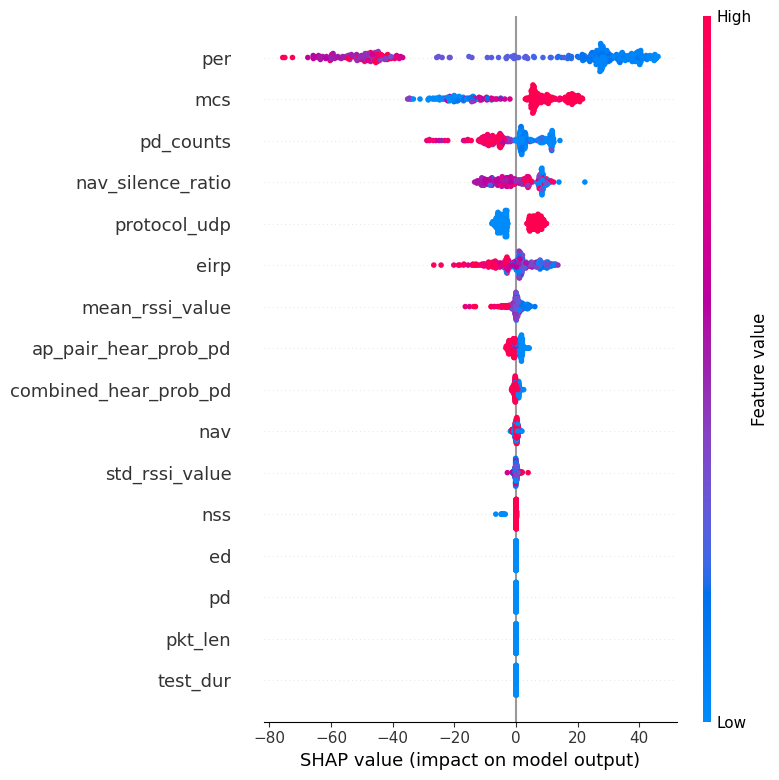

In [94]:
import shap
import numpy as np

# 训练随机森林模型
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# 使用 SHAP 进行解释
explainer = shap.Explainer(rf_model, X_train)  # 适用于随机森林
shap_values = explainer(X_train, check_additivity=False)

# 绘制特征重要性
shap.summary_plot(shap_values, X_train)

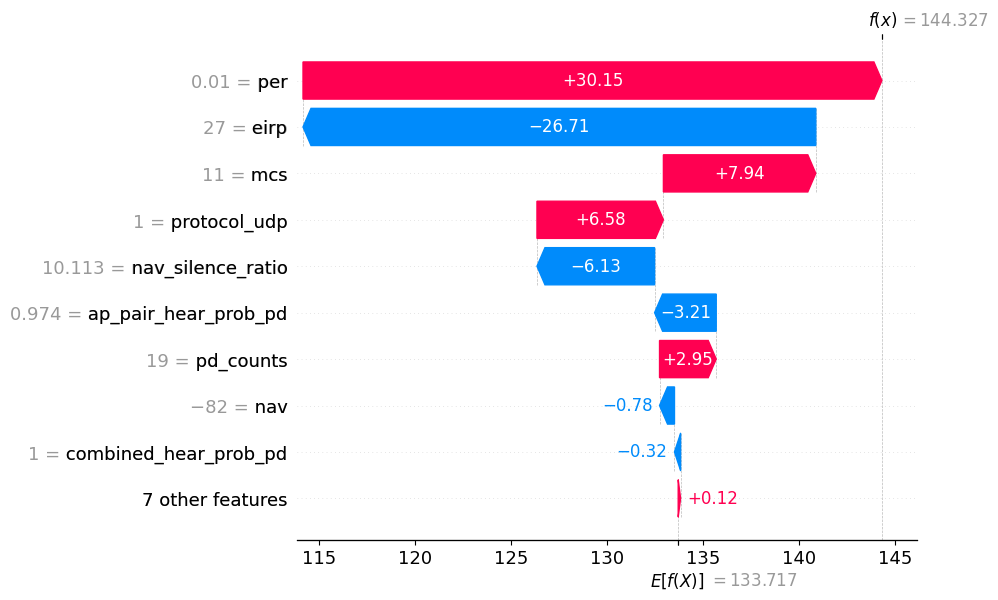

In [95]:
sample_index = 0
shap.plots.waterfall(shap_values[sample_index])

In [96]:
X.columns

Index(['test_dur', 'pkt_len', 'pd', 'ed', 'nav', 'eirp', 'nss', 'mcs', 'per',
       'mean_rssi_value', 'std_rssi_value', 'combined_hear_prob_pd',
       'nav_silence_ratio', 'pd_counts', 'ap_pair_hear_prob_pd',
       'protocol_udp'],
      dtype='object')

In [97]:
X['nss']

0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
      ... 
387    2.0
388    2.0
389    2.0
390    2.0
391    1.0
Name: nss, Length: 392, dtype: float64

In [98]:
import pandas as pd

# 创建初始数据
data = {
    'mcs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]*2,
    'nss': [1]*12 + [2]*12,
    '值': [8.6, 17.2, 25.8, 34.4, 51.6, 68.8, 77.4, 86.0, 103.2, 114.7, 129.0, 143.4,
           17.2, 34.4, 51.6, 68.8, 103.2, 137.6, 154.9, 172.1, 206.5, 229.4, 258.1, 286.8]
}

df = pd.DataFrame(data)

# 去除重复的值并排序
unique_values = df['值'].unique()
unique_values.sort()

# 创建值到编号的映射
value_to_id = {v: idx+1 for idx, v in enumerate(unique_values)}

# 添加编号列
df['编号'] = df['值'].map(value_to_id)

print(df)


    mcs  nss      值  编号
0     0    1    8.6   1
1     1    1   17.2   2
2     2    1   25.8   3
3     3    1   34.4   4
4     4    1   51.6   5
5     5    1   68.8   6
6     6    1   77.4   7
7     7    1   86.0   8
8     8    1  103.2   9
9     9    1  114.7  10
10   10    1  129.0  11
11   11    1  143.4  13
12    0    2   17.2   2
13    1    2   34.4   4
14    2    2   51.6   5
15    3    2   68.8   6
16    4    2  103.2   9
17    5    2  137.6  12
18    6    2  154.9  14
19    7    2  172.1  15
20    8    2  206.5  16
21    9    2  229.4  17
22   10    2  258.1  18
23   11    2  286.8  19


In [99]:
X

,test_dur,pkt_len,pd,ed,nav,eirp,nss,mcs,per,mean_rssi_value,std_rssi_value,combined_hear_prob_pd,nav_silence_ratio,pd_counts,ap_pair_hear_prob_pd,protocol_udp
0,60,1500,-82,-62,-82,9,2.0,11.0,0.02,-92.731707,0.542100,0.000000,0.000000,0.0,0.000000,0
1,60,1500,-82,-62,-82,9,2.0,11.0,0.03,-92.600000,0.938083,0.000000,0.000000,0.0,0.000000,0
2,60,1500,-82,-62,-82,9,2.0,11.0,0.01,-92.731707,0.542100,0.000000,0.000000,0.0,0.000000,1
3,60,1500,-82,-62,-82,9,2.0,11.0,0.01,-92.600000,0.938083,0.000000,0.000000,0.0,0.000000,1
4,60,1500,-82,-62,-82,10,2.0,11.0,0.01,-91.589744,0.668636,0.000000,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,60,1500,-82,-62,-82,27,2.0,11.0,0.05,-77.923077,1.071414,0.974359,8.961682,78.0,0.974359,0
388,60,1500,-82,-62,-82,28,2.0,11.0,0.06,-76.652778,1.492199,1.000000,9.060014,75.0,1.000000,0
389,60,1500,-82,-62,-82,28,2.0,11.0,0.05,-76.952381,1.111678,1.000000,8.543682,85.0,1.000000,0
390,60,1500,-82,-62,-82,28,2.0,11.0,0.03,-76.652778,1.492199,1.000000,0.060007,75.0,1.000000,1


In [100]:
X = X.merge(df[['mcs', 'nss', '值', '编号']], on=['mcs', 'nss'], how='left')


In [101]:
X[X['值'].isna()]

,test_dur,pkt_len,pd,ed,nav,eirp,nss,mcs,per,mean_rssi_value,std_rssi_value,combined_hear_prob_pd,nav_silence_ratio,pd_counts,ap_pair_hear_prob_pd,protocol_udp,值,编号
252,60,1500,-82,-62,-86,13,0.0,0.0,0.27,-72.0,0.0,1.0,10.765346,1.0,0.75,0,NaN,NaN


In [102]:
X = X.drop(index=252)

In [103]:
X

,test_dur,pkt_len,pd,ed,nav,eirp,nss,mcs,per,mean_rssi_value,std_rssi_value,combined_hear_prob_pd,nav_silence_ratio,pd_counts,ap_pair_hear_prob_pd,protocol_udp,值,编号
0,60,1500,-82,-62,-82,9,2.0,11.0,0.02,-92.731707,0.542100,0.000000,0.000000,0.0,0.000000,0,286.8,19.0
1,60,1500,-82,-62,-82,9,2.0,11.0,0.03,-92.600000,0.938083,0.000000,0.000000,0.0,0.000000,0,286.8,19.0
2,60,1500,-82,-62,-82,9,2.0,11.0,0.01,-92.731707,0.542100,0.000000,0.000000,0.0,0.000000,1,286.8,19.0
3,60,1500,-82,-62,-82,9,2.0,11.0,0.01,-92.600000,0.938083,0.000000,0.000000,0.0,0.000000,1,286.8,19.0
4,60,1500,-82,-62,-82,10,2.0,11.0,0.01,-91.589744,0.668636,0.000000,0.000000,0.0,0.000000,0,286.8,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,60,1500,-82,-62,-82,27,2.0,11.0,0.05,-77.923077,1.071414,0.974359,8.961682,78.0,0.974359,0,286.8,19.0
388,60,1500,-82,-62,-82,28,2.0,11.0,0.06,-76.652778,1.492199,1.000000,9.060014,75.0,1.000000,0,286.8,19.0
389,60,1500,-82,-62,-82,28,2.0,11.0,0.05,-76.952381,1.111678,1.000000,8.543682,85.0,1.000000,0,286.8,19.0
390,60,1500,-82,-62,-82,28,2.0,11.0,0.03,-76.652778,1.492199,1.000000,0.060007,75.0,1.000000,1,286.8,19.0


In [104]:
features_2 = ['test_dur', 'pkt_len', 'pd', 'ed', 'nav', 'eirp', 'per', 'mean_rssi_value', 
              'std_rssi_value', 'combined_hear_prob_pd', 'nav_silence_ratio', 'pd_counts','ap_pair_hear_prob_pd', 'protocol_udp']

In [105]:
X.columns

Index(['test_dur', 'pkt_len', 'pd', 'ed', 'nav', 'eirp', 'nss', 'mcs', 'per',
       'mean_rssi_value', 'std_rssi_value', 'combined_hear_prob_pd',
       'nav_silence_ratio', 'pd_counts', 'ap_pair_hear_prob_pd',
       'protocol_udp', '值', '编号'],
      dtype='object')

In [106]:
X_2 = X[features_2]
y_2 = X['编号']
y_2 = y_2.astype(int)

In [107]:
y_2.unique()

array([19,  9,  5,  6, 12,  7, 14,  1, 16, 15, 17, 18,  8])

In [108]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

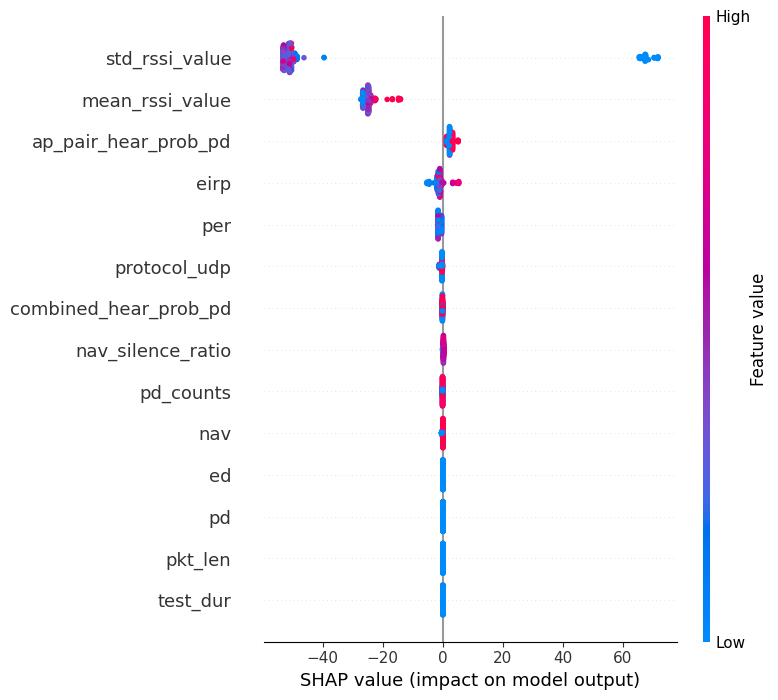

模型准确率: 0.8987341772151899
Classification Report:
              precision    recall  f1-score   support

           6       0.00      0.00      0.00         2
           9       0.55      0.86      0.67         7
          12       0.50      0.33      0.40         3
          15       0.00      0.00      0.00         0
          16       0.50      0.50      0.50         2
          17       1.00      0.67      0.80         3
          18       1.00      1.00      1.00         6
          19       1.00      0.98      0.99        56

    accuracy                           0.90        79
   macro avg       0.57      0.54      0.54        79
weighted avg       0.90      0.90      0.90        79

Confusion Matrix:
[[ 0  2  0  0  0  0  0  0]
 [ 0  6  1  0  0  0  0  0]
 [ 0  2  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  1  1  0  0  0]
 [ 0  0  0  0  1  2  0  0]
 [ 0  0  0  0  0  0  6  0]
 [ 0  1  0  0  0  0  0 55]]


d:\Users\ROG\anaconda3\envs\calf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\ROG\anaconda3\envs\calf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\ROG\anaconda3\envs\calf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Users\ROG\anaconda3\envs\calf\lib\si

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_2, y_train_2)
shap_values = explainer(X_train_2, check_additivity=False)  # 计算测试集的 SHAP 值

# 绘制特征重要性
shap.summary_plot(shap_values, X_train_2)
y_pred_encoded = rf_classifier.predict(X_test_2)

from sklearn.metrics import accuracy_score, classification_report

# 计算准确率
accuracy = accuracy_score(y_test_2, y_pred_encoded)
print("模型准确率:", accuracy)
print("Classification Report:")
print(classification_report(y_test_2, y_pred_encoded))

# (3) 混淆矩阵
print("Confusion Matrix:")
print(confusion_matrix(y_test_2, y_pred_encoded))


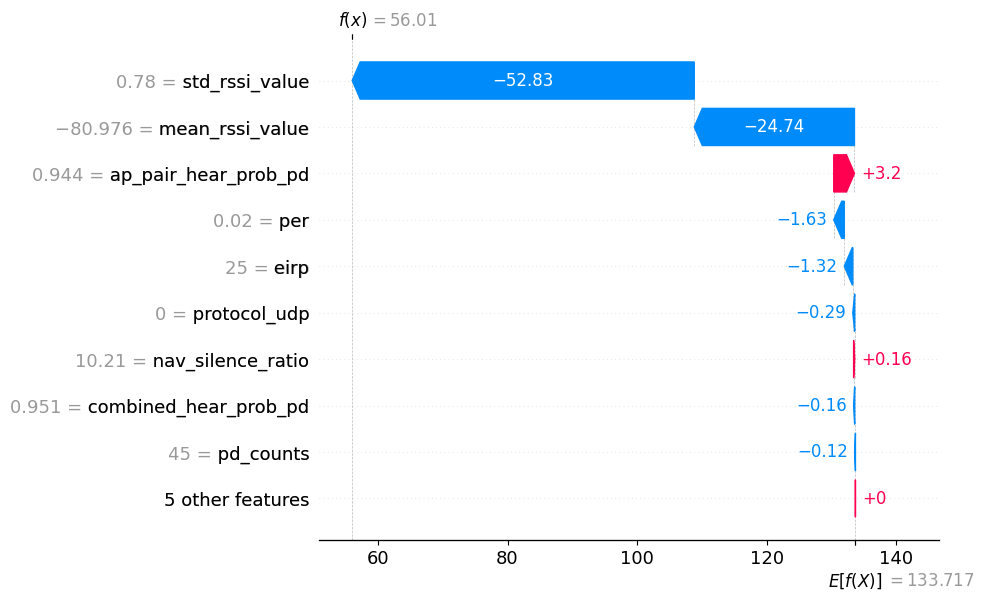

In [110]:
sample_index = 0
shap.plots.waterfall(shap_values[sample_index])

In [89]:
test_data = pd.read_csv("D:\\Data\\研赛建模\B题\\test_set_2_2ap.csv")

In [90]:
test_data.head(1)

,test_id,test_dur,loc_id,protocol,pkt_len,bss_id,ap_name,ap_mac,ap_id,pd,ed,nav,eirp,ap_from_ap_0_sum_ant_rssi,ap_from_ap_0_max_ant_rssi,ap_from_ap_0_mean_ant_rssi,ap_from_ap_1_sum_ant_rssi,ap_from_ap_1_max_ant_rssi,ap_from_ap_1_mean_ant_rssi,sta_mac,sta_id,sta_to_ap_0_sum_ant_rssi,sta_to_ap_0_max_ant_rssi,sta_to_ap_0_mean_ant_rssi,sta_to_ap_1_sum_ant_rssi,sta_to_ap_1_max_ant_rssi,sta_to_ap_1_mean_ant_rssi,sta_from_ap_0_sum_ant_rssi,sta_from_ap_0_max_ant_rssi,sta_from_ap_0_mean_ant_rssi,sta_from_ap_1_sum_ant_rssi,sta_from_ap_1_max_ant_rssi,sta_from_ap_1_mean_ant_rssi,sta_from_sta_0_rssi,sta_from_sta_1_rssi,nss,mcs,per,num_ampdu,ppdu_dur,other_air_time,seq_time,throughput,predict seq_time,error%,predict throughput,error%.1
0,1,60,loc3,tcp,1500,1,model-4,6c14-6ef5-9510,ap_1,-82,-62,-82,9,"[-82, -83, -83, -83, -83, -82, -83, -84, -87, ...","[-89, -91, -91, -90, -91, -89, -89, -91, -92, ...","[-91, -92, -92, -92, -92, -91, -92, -93, -96, ...",NaN,NaN,NaN,6d53,sta_1,"[-87, -87, -87, -87, -87, -67, -87, -82]","[-94, -92, -94, -94, -90, -69, -94, -93, -94, ...","[-96, -96, -95, -76, -96, -91]","[-68, -66, -67, -66, -67, -67, -68, -67, -67, ...","[-73, -72, -73, -71, -72, -71, -73, -73, -73, ...","[-77, -75, -76, -75, -76, -76, -76, -76, -76, ...",[-92],[-96],[-98],"[-73, -73, -73, -73, -74, -72, -72, -72, -72, ...","[-76, -76, -75, -75, -76, -74, -74, -74, -74, ...","[-76, -76, -76, -76, -77, -75, -75, -75, -75, ...",NaN,NaN,2,6,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
for col in rssi_columns:
    test_data[f"{col}_list"] = test_data[col].apply(str_to_float_list)

In [92]:
grouped_data_test = test_data.groupby('test_id')

In [93]:
for test_id, group in grouped_data_test:
    for col in rssi_columns:
        row_1 = group.iloc[0]
        row_2 = group.iloc[1]
        clean_rssi_row1 = kmeans_filter_rssi(row_1[f"{col}_list"])
        clean_rssi_row2 = kmeans_filter_rssi(row_2[f"{col}_list"])
        test_data.at[row_1.name, f"{col}_list"] = clean_rssi_row1
        test_data.at[row_2.name, f"{col}_list"] = clean_rssi_row2
        
        
        

C:\Users\ROG\AppData\Local\Temp\ipykernel_46644\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_46644\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_46644\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rssi_array)
C:\Users\ROG\AppData\Local\Temp\ipykernel_46644\2700997529.py:5: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  kmeans = KMeans

In [94]:
for test_id, group in grouped_data_test:
    # 检查每个测试是否有两行数据
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue  # 跳过这个测试

    # 获取两行数据
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    ap1_rssi_from_ap0 = test_data.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = test_data.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    def calculate_hearing_probability(rssi_list, threshold):
        if not rssi_list:
            return 0
        above_threshold = [rssi for rssi in rssi_list if rssi >= threshold]
        return len(above_threshold) / len(rssi_list)
    pd_threshold_1 = data_2.at[row_1.name, 'pd']
    pd_threshold_0 = data_2.at[row_2.name, 'pd']
    # 计算AP1从AP0接收到的互听概率（基于PD门限）
    ap1_hear_prob_pd = calculate_hearing_probability(ap1_rssi_from_ap0, pd_threshold_1)
    # 计算AP0从AP1接收到的互听概率（基于PD门限）
    ap0_hear_prob_pd = calculate_hearing_probability(ap0_rssi_from_ap1, pd_threshold_0)

    # 计算AP之间的互听概率（取最小值）
    ap_pair_hear_prob_pd = min(ap1_hear_prob_pd, ap0_hear_prob_pd)
    test_data.at[row_1.name, 'ap1_hear_prob_pd'] = ap1_hear_prob_pd
    test_data.at[row_2.name, 'ap0_hear_prob_pd'] = ap0_hear_prob_pd
    test_data.at[row_1.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd
    test_data.at[row_2.name, 'ap_pair_hear_prob_pd'] = ap_pair_hear_prob_pd

In [95]:
SIFS = 16  # 微秒
ACK_duration = 32  # 微秒
def can_hear_each_other(rssi_list, nav_threshold):
    if not rssi_list:
        return False
    return any(rssi >= nav_threshold for rssi in rssi_list)

def calculate_nav_period(seq_time_microseconds):
    return seq_time_microseconds + SIFS + ACK_duration  # 单位：微秒

In [96]:
SIFS = 16  # 微秒
ACK_duration = 32  # 微秒
def can_hear_each_other(rssi_list, nav_threshold):
    if not rssi_list:
        return False
    return any(rssi >= nav_threshold for rssi in rssi_list)

def calculate_nav_period(seq_time_microseconds):
    return seq_time_microseconds + SIFS + ACK_duration  # 单位：微秒

In [97]:
for test_id, group in grouped_data_test:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue
    
    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    
    # 获取nav_threshold
    nav_threshold = test_data.at[row_1.name, 'nav']
    # print(f"Test ID: {test_id}, NAV Threshold: {nav_threshold}")
    
    # 获取去噪后的RSSI列表
    ap1_rssi_from_ap0 = test_data.at[row_1.name, 'ap_from_ap_0_mean_ant_rssi_list']
    ap0_rssi_from_ap1 = test_data.at[row_2.name, 'ap_from_ap_1_mean_ant_rssi_list']
    
    # print(f"AP1 RSSI from AP0: {ap1_rssi_from_ap0}, AP0 RSSI from AP1: {ap0_rssi_from_ap1}")
    
    # 判断互听情况
    ap1_can_hear_ap0 = can_hear_each_other(ap1_rssi_from_ap0, nav_threshold)
    ap0_can_hear_ap1 = can_hear_each_other(ap0_rssi_from_ap1, nav_threshold)
    
    # print(f"AP1 can hear AP0: {ap1_can_hear_ap0}, AP0 can hear AP1: {ap0_can_hear_ap1}")
    
    # 初始化NAV静默总时间
    ap1_nav_silence_time = 0
    ap0_nav_silence_time = 0
    
    # 计算AP1的NAV静默时间
    if ap1_can_hear_ap0:
        seq_time_ap0 = row_2['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap1 = calculate_nav_period(seq_time_ap0)
        num_transmissions_ap0 = row_2['num_ampdu']
        ap1_nav_silence_time = nav_period_ap1 * num_transmissions_ap0
        # print(f"AP1 NAV Silence Time: {ap1_nav_silence_time}")
    else:
        ap1_nav_silence_time = 0
        # print("AP1 cannot hear AP0, NAV Silence Time set to 0.")
    
    # 计算AP0的NAV静默时间
    if ap0_can_hear_ap1:
        seq_time_ap1 = row_1['seq_time'] * 1e6  # 将秒转换为微秒
        nav_period_ap0 = calculate_nav_period(seq_time_ap1)
        num_transmissions_ap1 = row_1['num_ampdu']
        ap0_nav_silence_time = nav_period_ap0 * num_transmissions_ap1
        # print(f"AP0 NAV Silence Time: {ap0_nav_silence_time}")
    else:
        ap0_nav_silence_time = 0
        # print("AP0 cannot hear AP1, NAV Silence Time set to 0.")
    
    # 获取测试总时长
    test_duration = row_1['test_dur'] * 1e6  # 将秒转换为微秒
    print(f"Test Duration (in µs): {test_duration}")
    
    # 计算NAV静默比例
    if test_duration != 0:
        ap1_nav_silence_ratio = ap1_nav_silence_time / test_duration
        ap0_nav_silence_ratio = ap0_nav_silence_time / test_duration
    else:
        ap1_nav_silence_ratio = 0
        ap0_nav_silence_ratio = 0
        print("Test duration is 0, silence ratios set to 0.")
    
    print(f"AP1 NAV Silence Ratio: {ap1_nav_silence_ratio}, AP0 NAV Silence Ratio: {ap0_nav_silence_ratio}")
    
    # 存储结果
    test_data.at[row_1.name, 'ap1_nav_silence_time'] = ap1_nav_silence_time
    test_data.at[row_2.name, 'ap0_nav_silence_time'] = ap0_nav_silence_time
    test_data.at[row_1.name, 'ap1_nav_silence_ratio'] = ap1_nav_silence_ratio
    test_data.at[row_2.name, 'ap0_nav_silence_ratio'] = ap0_nav_silence_ratio


Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: 0.0, AP0 NAV Silence Ratio: 0.0
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: 0.0, AP0 NAV Silence Ratio: 0.0
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: 0.0, AP0 NAV Silence Ratio: 0.0
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: 0.0, AP0 NAV Silence Ratio: 0.0
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: 0.0, AP0 NAV Silence Ratio: 0.0
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: 0.0, AP0 NAV Silence Ratio: 0.0
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: nan, AP0 NAV Silence Ratio: 0.0
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: nan, AP0 NAV Silence Ratio: 0.0
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: nan, AP0 NAV Silence Ratio: 0.0
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: nan, AP0 NAV Silence Ratio: 0.0
Test Duration (in µs): 60000000.0
AP1 NAV Silence Ratio: 0.0, AP0 NAV Silence Ratio: nan
Test Duration (in µs)

In [98]:
for test_id, group in grouped_data_test:
    if len(group) != 2:
        print(f"测试ID {test_id} 的数据行数不是2行，实际为 {len(group)} 行。请检查数据。")
        continue

    row_1 = group.iloc[0]
    row_2 = group.iloc[1]
    # print(row_1)
    # 获取ap0的RSSI值，并打印出来进行检查
    ap0_rssi_from_ap1 = test_data.at[row_1.name, 'ap_from_ap_0_max_ant_rssi_list']
    # print(f"测试ID {test_id}: ap0_rssi_from_ap1 = {ap0_rssi_from_ap1}")
    
    # 获取ap0的pd阈值，并打印出来进行检查
    pd_threshold_ap0 = row_1['pd']
    # print(f"测试ID {test_id}: pd_threshold_ap0 = {pd_threshold_ap0}")

    # 计算ap0的pd计数，并打印结果
    ap0_pd_counts = calculate_pd_counts(ap0_rssi_from_ap1, pd_threshold_ap0)
    # print(f"测试ID {test_id}: ap0_pd_counts = {ap0_pd_counts}")

    # 获取ap1的RSSI值，并打印出来进行检查
    ap1_rssi_from_ap0 = test_data.at[row_2.name, 'ap_from_ap_1_max_ant_rssi_list']
    # print(f"测试ID {test_id}: ap1_rssi_from_ap0 = {ap1_rssi_from_ap0}")

    # 获取ap1的pd阈值，并打印出来进行检查
    pd_threshold_ap1 = row_2['pd']  # 如果pd列有变化，使用AP1的实际PD门限值
    # print(f"测试ID {test_id}: pd_threshold_ap1 = {pd_threshold_ap1}")

    # 计算ap1的pd计数，并打印结果
    ap1_pd_counts = calculate_pd_counts(ap1_rssi_from_ap0, pd_threshold_ap1)
    # print(f"测试ID {test_id}: ap1_pd_counts = {ap1_pd_counts}")

    # 将计算结果写入data，并打印确认
    test_data.at[row_1.name, 'ap0_pd_counts'] = ap0_pd_counts
    test_data.at[row_2.name, 'ap1_pd_counts'] = ap1_pd_counts
    # print(f"测试ID {test_id}: 写入数据 - ap0_pd_counts = {ap0_pd_counts}, ap1_pd_counts = {ap1_pd_counts}")


    

In [99]:
new_col = 'mean_rssi_value'
def list_mean(lst):
    return sum(lst) / len(lst) if lst else None
test_data[new_col] = test_data.apply(lambda row: list_mean(row['ap_from_ap_0_mean_ant_rssi_list']) 
                           if row.name % 2 == 0 
                           else list_mean(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)


In [100]:
new_col_2 = 'std_rssi_value'
def list_std(lst):
    return np.std(lst) if lst else None

test_data[new_col_2] = test_data.apply(lambda row: list_std(row['ap_from_ap_0_mean_ant_rssi_list'])
                             if row.name % 2 == 0
                             else list_std(row['ap_from_ap_1_mean_ant_rssi_list']), axis=1)

In [101]:
new_col_3 = 'combined_hear_prob_pd'

# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
test_data[new_col_3] = test_data.apply(lambda row: alternate_values(row.name, test_data['ap1_hear_prob_pd'], test_data['ap0_hear_prob_pd']), axis=1)

In [102]:
new_col_4 = 'nav_silence_ratio'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
test_data[new_col_4] = test_data.apply(lambda row: alternate_values(row.name, test_data['ap1_nav_silence_ratio'], test_data['ap0_nav_silence_ratio']), axis=1)

In [103]:
new_col_5 = 'pd_counts'
# 定义一个函数，用于交替获取两个列的值
def alternate_values(row_index, col1, col2):
    if row_index % 2 == 0:  # 偶数行取col1的值
        return col1[row_index]
    else:  # 奇数行取col2的值
        return col2[row_index]

# 使用apply函数进行行操作，交替取值
test_data[new_col_5] = test_data.apply(lambda row: alternate_values(row.name, test_data['ap0_pd_counts'], test_data['ap1_pd_counts']), axis=1)

In [104]:
test_data = pd.get_dummies(test_data[features], columns=['protocol'], drop_first=True)

In [105]:
test_data.head(1)

,test_dur,pkt_len,pd,ed,nav,eirp,nss,mcs,per,mean_rssi_value,std_rssi_value,combined_hear_prob_pd,nav_silence_ratio,pd_counts,ap_pair_hear_prob_pd,protocol_udp
0,60,1500,-82,-62,-82,9,2,6,0.05,-91.741935,0.43757,0.0,0.0,0.0,0.0,0


In [106]:
features_test = [
    'test_dur', 'protocol_udp', 'pkt_len', 'pd', 'ed', 'nav',
    'eirp', 'nss', 'mcs', 'per', 'mean_rssi_value', 'std_rssi_value', 'combined_hear_prob_pd', 'nav_silence_ratio', 'pd_counts', 'ap_pair_hear_prob_pd'
]

In [196]:
X['nav_silence_ratio']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
         ...    
387     8.961682
388     9.060014
389     8.543682
390     0.060007
391    15.740016
Name: nav_silence_ratio, Length: 391, dtype: float64

In [110]:
test_data[features_test]
filled = test_data[features_test]['nav_silence_ratio'].fillna(15)
test_data['nav_silence_ratio'] = filled
test_data[features_test]
# test_data[features_test]['nav_silence_ratio'].fillna(15, inplace=True)
# test_data[features_test]
# test_data.head(1)
# test_data = pd.get_dummies(test_data, columns=['protocol'], drop_first=True)
# test_data = test_data.drop('loc_id', axis=1)
# test_data
test_predictions = rf_model.predict(test_data[features_test])
test_predictions_plus_117 = test_predictions + 117
# 打印或查看预测结果
print(test_predictions_plus_117)

[163.87605 163.8857  163.87605 163.8857  163.8139  163.87605 163.8139
 163.87605 163.8139  163.8857  163.8139  163.8857  164.7251  163.8139
 164.7251  163.8139  164.8468  163.8139  164.8468  163.8139  163.54705
 164.7251  163.54705 164.7251  163.54705 164.7251  163.54705 164.7251
 163.54705 163.54705 163.54705 163.54705 163.54705 163.54705 163.54705
 163.54705 164.70055 163.54705 164.70055 163.54705 164.70055 163.54705
 164.70055 163.54705 164.70055 164.70055 164.70055 164.70055 165.5818
 165.56875 165.5818  165.56875 165.5818  165.5818  165.5818  165.5818
 165.5818  165.56875 165.5818  165.56875 165.56875 165.56875 165.56875
 165.56875 165.5818  165.5818  165.5818  165.5818  165.5818  165.5818
 165.5818  165.5818  165.5818  165.5818  165.56875 165.5818  165.5818
 165.5818  165.5818  165.5818 ]


d:\Users\ROG\anaconda3\envs\calf\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [111]:
test_predictions_plus_117

array([163.87605, 163.8857 , 163.87605, 163.8857 , 163.8139 , 163.87605,
       163.8139 , 163.87605, 163.8139 , 163.8857 , 163.8139 , 163.8857 ,
       164.7251 , 163.8139 , 164.7251 , 163.8139 , 164.8468 , 163.8139 ,
       164.8468 , 163.8139 , 163.54705, 164.7251 , 163.54705, 164.7251 ,
       163.54705, 164.7251 , 163.54705, 164.7251 , 163.54705, 163.54705,
       163.54705, 163.54705, 163.54705, 163.54705, 163.54705, 163.54705,
       164.70055, 163.54705, 164.70055, 163.54705, 164.70055, 163.54705,
       164.70055, 163.54705, 164.70055, 164.70055, 164.70055, 164.70055,
       165.5818 , 165.56875, 165.5818 , 165.56875, 165.5818 , 165.5818 ,
       165.5818 , 165.5818 , 165.5818 , 165.56875, 165.5818 , 165.56875,
       165.56875, 165.56875, 165.56875, 165.56875, 165.5818 , 165.5818 ,
       165.5818 , 165.5818 , 165.5818 , 165.5818 , 165.5818 , 165.5818 ,
       165.5818 , 165.5818 , 165.56875, 165.5818 , 165.5818 , 165.5818 ,
       165.5818 , 165.5818 ])

In [109]:
len(test_predictions)

80

In [197]:
test_new = test_data[features_test].merge(df[['mcs', 'nss', '值', '编号']], on=['mcs', 'nss'], how='left')

In [198]:
test_new

,test_dur,protocol_udp,pkt_len,pd,ed,nav,eirp,nss,mcs,per,mean_rssi_value,std_rssi_value,combined_hear_prob_pd,nav_silence_ratio,pd_counts,ap_pair_hear_prob_pd,值,编号
0,60,0,1500,-82,-62,-86,9,NaN,NaN,NaN,-82.375000,5.984790,0.333333,NaN,24.0,0.333333,NaN,NaN
1,60,0,1500,-82,-62,-86,9,NaN,NaN,NaN,-77.222222,4.565031,1.000000,NaN,36.0,0.333333,NaN,NaN
2,60,1,1500,-82,-62,-86,9,NaN,NaN,NaN,-82.375000,5.984790,0.333333,NaN,24.0,0.333333,NaN,NaN
3,60,1,1500,-82,-62,-86,9,NaN,NaN,NaN,-77.222222,4.565031,1.000000,NaN,36.0,0.333333,NaN,NaN
4,60,0,1500,-82,-62,-86,10,NaN,NaN,NaN,-84.925926,6.097516,0.111111,NaN,23.0,0.111111,NaN,NaN
5,60,0,1500,-82,-62,-86,10,NaN,NaN,NaN,-78.230769,1.873726,1.000000,NaN,45.0,0.111111,NaN,NaN
6,60,1,1500,-82,-62,-86,10,NaN,NaN,NaN,-84.925926,6.097516,0.111111,NaN,23.0,0.111111,NaN,NaN
7,60,1,1500,-82,-62,-86,10,NaN,NaN,NaN,-78.230769,1.873726,1.000000,NaN,45.0,0.111111,NaN,NaN
8,60,0,1500,-82,-62,-86,12,NaN,NaN,NaN,-59.666667,0.471405,1.000000,NaN,26.0,1.000000,NaN,NaN
9,60,0,1500,-82,-62,-86,12,NaN,NaN,NaN,-75.170732,3.615026,1.000000,NaN,47.0,1.000000,NaN,NaN


In [200]:
test_new_2 = test_new[features_2]

In [201]:
test_new_2

,test_dur,pkt_len,pd,ed,nav,eirp,per,mean_rssi_value,std_rssi_value,combined_hear_prob_pd,nav_silence_ratio,pd_counts,ap_pair_hear_prob_pd,protocol_udp
0,60,1500,-82,-62,-86,9,NaN,-82.375000,5.984790,0.333333,NaN,24.0,0.333333,0
1,60,1500,-82,-62,-86,9,NaN,-77.222222,4.565031,1.000000,NaN,36.0,0.333333,0
2,60,1500,-82,-62,-86,9,NaN,-82.375000,5.984790,0.333333,NaN,24.0,0.333333,1
3,60,1500,-82,-62,-86,9,NaN,-77.222222,4.565031,1.000000,NaN,36.0,0.333333,1
4,60,1500,-82,-62,-86,10,NaN,-84.925926,6.097516,0.111111,NaN,23.0,0.111111,0
5,60,1500,-82,-62,-86,10,NaN,-78.230769,1.873726,1.000000,NaN,45.0,0.111111,0
6,60,1500,-82,-62,-86,10,NaN,-84.925926,6.097516,0.111111,NaN,23.0,0.111111,1
7,60,1500,-82,-62,-86,10,NaN,-78.230769,1.873726,1.000000,NaN,45.0,0.111111,1
8,60,1500,-82,-62,-86,12,NaN,-59.666667,0.471405,1.000000,NaN,26.0,1.000000,0
9,60,1500,-82,-62,-86,12,NaN,-75.170732,3.615026,1.000000,NaN,47.0,1.000000,0


In [202]:
test_new_2.fillna(0, inplace=True)

test_new_2.replace([np.inf, -np.inf], 0, inplace=True)
test_new_2

C:\Users\ROG\AppData\Local\Temp\ipykernel_46496\1969478870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new_2.fillna(0, inplace=True)
C:\Users\ROG\AppData\Local\Temp\ipykernel_46496\1969478870.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new_2.replace([np.inf, -np.inf], 0, inplace=True)


,test_dur,pkt_len,pd,ed,nav,eirp,per,mean_rssi_value,std_rssi_value,combined_hear_prob_pd,nav_silence_ratio,pd_counts,ap_pair_hear_prob_pd,protocol_udp
0,60,1500,-82,-62,-86,9,0.0,-82.375000,5.984790,0.333333,0.0,24.0,0.333333,0
1,60,1500,-82,-62,-86,9,0.0,-77.222222,4.565031,1.000000,0.0,36.0,0.333333,0
2,60,1500,-82,-62,-86,9,0.0,-82.375000,5.984790,0.333333,0.0,24.0,0.333333,1
3,60,1500,-82,-62,-86,9,0.0,-77.222222,4.565031,1.000000,0.0,36.0,0.333333,1
4,60,1500,-82,-62,-86,10,0.0,-84.925926,6.097516,0.111111,0.0,23.0,0.111111,0
5,60,1500,-82,-62,-86,10,0.0,-78.230769,1.873726,1.000000,0.0,45.0,0.111111,0
6,60,1500,-82,-62,-86,10,0.0,-84.925926,6.097516,0.111111,0.0,23.0,0.111111,1
7,60,1500,-82,-62,-86,10,0.0,-78.230769,1.873726,1.000000,0.0,45.0,0.111111,1
8,60,1500,-82,-62,-86,12,0.0,-59.666667,0.471405,1.000000,0.0,26.0,1.000000,0
9,60,1500,-82,-62,-86,12,0.0,-75.170732,3.615026,1.000000,0.0,47.0,1.000000,0


In [203]:
test_predictions_2 = rf_classifier.predict(test_new_2)

In [204]:
test_predictions_2

array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19])